# **Analyse in Pandas en PowerBI**
**Groep 8** <br>
&nbsp;&nbsp;&nbsp;&nbsp;*Kyana Marckx* <br>
&nbsp;&nbsp;&nbsp;&nbsp;*Levi Matthijs* <br>
&nbsp;&nbsp;&nbsp;&nbsp;*Robin De Waegeneer* <br>
&nbsp;&nbsp;&nbsp;&nbsp;*Siebe Van Der Donck*

## Ter info

***Airport iata codes*** <br>
&nbsp;&nbsp;&nbsp;&nbsp;**FR** = Ryanair <br>
&nbsp;&nbsp;&nbsp;&nbsp;**SN** = Brussels Airlines <br>
&nbsp;&nbsp;&nbsp;&nbsp;**HV** = Transavia <br>
&nbsp;&nbsp;&nbsp;&nbsp;**TB** = Tui

## Imports

In [1]:
import os
import csv
import sys
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector as sql
from dotenv import load_dotenv

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR

warnings.filterwarnings('ignore')

dotenv_path = "../.env"
load_dotenv(dotenv_path)

True

## Data

### Datawarehouse MySQL Workbench

In [2]:
# make a connection to the database
dwh = sql.connect(
    host="127.0.0.1",   # ip-adres
    port=3306,   # poortnummer
    user=os.getenv("USER"),   # username
    password=os.getenv("PASSWORD"),   # wachtwoord
    database="AirFaresDWH"   # naam van de datawarehouse in mysql workbench
    # database="groep8dep"   # naam van de OLTP database in mysql workbench
)

# check if the connection succeeded
print(dwh)

In [3]:
# create cursor
cursor = dwh.cursor()

# use the right database
cursor.execute("USE AirFaresDWH")

# create query
query = """
SELECT
  dep_airport.airport_key, dep_airport.airport_iata_code, dep_airport.airport_name, dep_airport.location, dep_airport.country,
  airline.airline_key, airline.airline_iata_code, airline.airline_name, airline.country,
  flight.flight_key, flight.flight_id, flight.flightnumber, flight.numberOfStops, flight.departureTime, flight.arrivalTime, flight.duration, flight.start_date, flight.end_date,
  dep_date.date_key, dep_date.date, dep_date.day_of_week, dep_date.day_of_month, dep_date.day_of_year, dep_date.year, dep_date.dayName, dep_date.monthName, dep_date.nameOfQuarter, dep_date.numberOfQuarter, dep_date.isWeekend, dep_date.isWeekDay, dep_date.isHoliday,
  fact.flightfare_key, fact.flight_key, fact.airline_key, fact.depatureAirportKey, fact.arrivalAirportKey, fact.scrapeDateKey, fact.departureDateKey, fact.arrivalDateKey, fact.availableSeats, fact.price
FROM factflightfare AS fact
JOIN dimairline AS airline ON fact.airline_key = airline.airline_key
JOIN dimairport AS dep_airport ON fact.depatureAirportKey = dep_airport.airport_key
JOIN dimairport AS arr_airport ON fact.arrivalAirportKey = arr_airport.airport_key
JOIN dimflight AS flight ON fact.flight_key = flight.flight_key
JOIN dimdate AS dep_date ON fact.departureDateKey = dep_date.date_key
JOIN dimdate AS arr_date ON fact.arrivalDateKey = arr_date.date_key
JOIN dimdate AS scrape_date ON fact.scrapeDateKey = scrape_date.date_key
"""

# create the dataframe while reading query
df = pd.read_sql(query, dwh)

# show the df
df

,airport_key,airport_iata_code,airport_name,location,country,airline_key,airline_iata_code,airline_name,country,flight_key,...,flightfare_key,flight_key,airline_key,depatureAirportKey,arrivalAirportKey,scrapeDateKey,departureDateKey,arrivalDateKey,availableSeats,price
0,5,BRU,Brussels Airline,Zaventem,Belgium,1,FR,Ryanair,Ireland,1,...,51288,1,1,5,1,20230414,20230416,20230416,2,103.51
1,5,BRU,Brussels Airline,Zaventem,Belgium,1,FR,Ryanair,Ireland,1,...,61671,1,1,5,1,20230411,20230416,20230416,3,127.99
2,5,BRU,Brussels Airline,Zaventem,Belgium,1,FR,Ryanair,Ireland,1,...,66100,1,1,5,1,20230409,20230416,20230416,3,136.55
3,5,BRU,Brussels Airline,Zaventem,Belgium,1,FR,Ryanair,Ireland,1,...,96112,1,1,5,1,20230407,20230416,20230416,5,130.13
4,5,BRU,Brussels Airline,Zaventem,Belgium,1,FR,Ryanair,Ireland,1,...,102025,1,1,5,1,20230412,20230416,20230416,5,106.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182280,13,OST,Oostende-Brugge International Airport,Ostend,Belgium,4,TB,Tui,Belgium,5593,...,178505,5593,4,13,17,20230426,20231004,20231004,-1,249.99
182281,13,OST,Oostende-Brugge International Airport,Ostend,Belgium,4,TB,Tui,Belgium,5593,...,179961,5593,4,13,17,20230423,20231004,20231004,-1,249.99
182282,13,OST,Oostende-Brugge International Airport,Ostend,Belgium,4,TB,Tui,Belgium,5593,...,181394,5593,4,13,17,20230417,20231004,20231004,-1,249.99
182283,13,OST,Oostende-Brugge International Airport,Ostend,Belgium,4,TB,Tui,Belgium,5593,...,187466,5593,4,13,17,20230429,20231004,20231004,-1,249.99


## General functions

### Functie voor arrivalAirportKey te switchen naar de bijhorende airportName

In [4]:
def switch_arrival_airport_key(key):
    match key:
        case 1:
            key = 'Malaga'
        case 2:
            key = 'Alicante'
        case 4:
            key = 'Brindisi'
        case 6:
            key = 'Corfu'
        case 8:
            key = 'Faro'
        case 9:
            key = 'Kreta'
        case 10:
            key = 'Ibiza'
        case 12:
            key = 'Napels'
        case 14:
            key = 'Palma'
        case 15:
            key = 'Palermo'
        case 16:
            key = 'Rhodos'
        case 17:
            key = 'Tenerife'
    return key

### Functie voor de arrivalAirportName terug te switchen naar de arrivalAirportKey

In [5]:
def switch_arrival_airport_key_back(key):
    match key:
        case 'Malaga':
            key = 1
        case 'Alicante':
            key = 2
        case 'Brindisi':
            key = 4
        case 'Corfu':
            key = 6
        case 'Faro':
            key = 8
        case 'Kreta':
            key = 9
        case 'Ibiza':
            key = 10
        case 'Napels':
            key = 12
        case 'Palma':
            key = 14
        case 'Palermo':
            key = 15
        case 'Rhodos':
            key = 16
        case 'Tenerife':
            key = 17
    return key

## Questions

### 1) Welke vliegtuigmaatschappij is gemiddeld de goedkoopste / de duurste?

**PowerBI** &nbsp;&nbsp; *Vraag 1*

De goedkoopste vliegtuigmaatschappij is Ryanair met een gemiddelde prijs van 116.95 euro.
De duurste vliegtuigmaatschappij is Tui met een gemiddelde prijs van 200.07 euro.


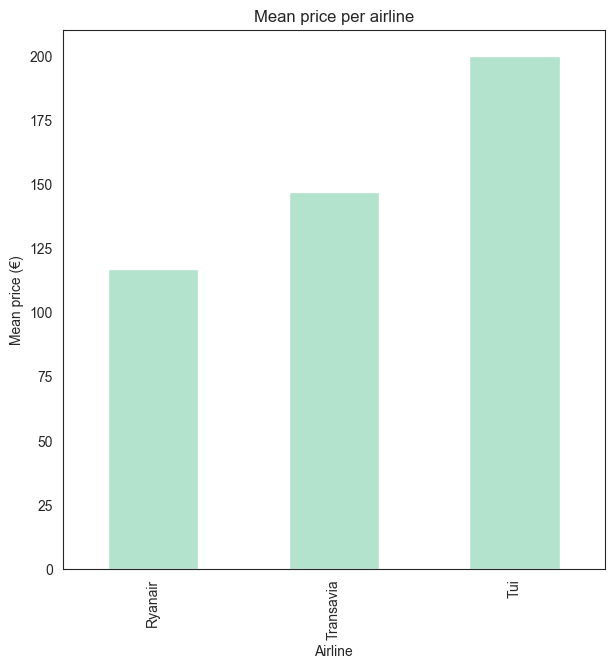

In [6]:
# read the data
data = df

# group the data by airline and calculate the average price
grouped_data = data.groupby(['airline_name'])['price'].mean()
sorted_data = grouped_data.sort_values()

# print the results
print("De goedkoopste vliegtuigmaatschappij is " + sorted_data.index[0] + " met een gemiddelde prijs van", round(sorted_data[0], 2), "euro.")
print("De duurste vliegtuigmaatschappij is " + sorted_data.index[-1] + " met een gemiddelde prijs van", round(sorted_data[-1], 2), "euro.")

# plot the results

plt.figure(figsize=(7, 7))
plt.style.use('default')
sns.set_style('white')
grouped_data.plot(kind='bar', colormap='Pastel2')
plt.title('Mean price per airline')
plt.xlabel('Airline')
plt.ylabel('Mean price (€)')
plt.show()

### 2) Hoe vaak vliegt elke vliegtuigmaatschappij per week naar elk van de bestemmingen?

**PowerBI** &nbsp;&nbsp; *Vraag 2*, *Vraag 2 deel 2*, *Vraag 2 deel 3*

#### CSV voor de vluchten per bestemming per week

In [7]:
# read the data
data = df

# add the switched arrival airport name to the dataframe
data['arrivalAirportKey'] = data['arrivalAirportKey'].apply(switch_arrival_airport_key)

# open new csv file
with open('../analyse/flightsPerWeek.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['airline_name', 'arrivalAirportKey', 'weekNr', 'countOfFlights'])

# iterate over the data and add to array
dataArr = []
for i in range(len(data)):
    dataArr.append(data.iloc[i])

# initialize dictionary to store flights per airline per destination per week
flights_per_week = {}

# loop through the rows
for row in dataArr:
    airline = row['airline_name']
    destination = row['arrivalAirportKey']
    departure_date = row['departureDateKey']

    # convert departure date to datetime object
    departure_date_obj = datetime.datetime.strptime(str(departure_date), '%Y%m%d')

    # extract week number
    week_number = departure_date_obj.strftime('%W')

    # add info to flights_per_week dictionary
    if airline not in flights_per_week:
        flights_per_week[airline] = {}
    if destination not in flights_per_week[airline]:
        flights_per_week[airline][destination] = {}
    if week_number not in flights_per_week[airline][destination]:
        flights_per_week[airline][destination][week_number] = 0
    flights_per_week[airline][destination][week_number] += 1

with open('../analyse/flightsPerWeek.csv', 'a', newline='') as csv_file:
    # create csv writer
    writer = csv.writer(csv_file)

    # print flights per airline per destination per week
    for airline, destinations in flights_per_week.items():
        for destination, weeks in destinations.items():
            for week, num_flights in weeks.items():
                # print(f"Airline: {airline}, Destination: {destination}, Week: {week}, Flights: {num_flights}")
                writer.writerow([airline, destination, week, num_flights])

#### Extra analyses

##### Totaal aantal vluchten per vliegtuigmaatschappij

In [8]:
# read the data
data = df

# add new column for weekday
data['weekday'] = pd.to_datetime(data['departureDateKey']).dt.day_name()

# group the data by airline and destination + count the number of flights per week
grouped_data = data.groupby(['airline_name', 'arrivalAirportKey', 'weekday']).size().reset_index(name='countOfFlights')

pivoted_data = pd.pivot_table(grouped_data, values='countOfFlights', index=['airline_name'], columns=['arrivalAirportKey', 'weekday'], fill_value=0)

sorted_data = pivoted_data.sort_values(by=['airline_name'])

pd.DataFrame(sorted_data)

for i in range(len(sorted_data)):
    print("De vliegtuigmaatschappij " + sorted_data.index[i] + " heeft", sorted_data.iloc[i].sum(), "in totaal.")

De vliegtuigmaatschappij Ryanair heeft 66642 in totaal.
De vliegtuigmaatschappij Transavia heeft 18506 in totaal.
De vliegtuigmaatschappij Tui heeft 97137 in totaal.


##### Totaal aantal vluchten per vliegtuigmaatschappij per bestemming

In [9]:
# read the data
data = df

# iterate over the data and add to array
dataArr = []
for i in range(len(data)):
    dataArr.append(data.iloc[i])

# create dictionary to hold count of flights per airline and destination
flights_count = {}

# iterate over flights and update count in dictionary
for flight in dataArr:
    airline = flight['airline_name']
    destination = flight['arrivalAirportKey']
    if airline not in flights_count:
        flights_count[airline] = {}
    if destination not in flights_count[airline]:
        flights_count[airline][destination] = 0
    flights_count[airline][destination] += 1

# create list of airlines and destinations
airlines = list(flights_count.keys())
destinations = list(set(dest for dests in flights_count.values() for dest in dests.keys()))

# print table header
print('Airline'.ljust(15), end='')
for dest in destinations:
    # switch the dest to the correct airport name
    dest = switch_arrival_airport_key(dest)
    print(str(dest).rjust(10), end='')
print('')

# print table body
for airline in airlines:
    print(airline.ljust(15), end='')
    for dest in destinations:
        count = flights_count.get(airline, {}).get(dest, 0)
        print(str(count).rjust(10), end='')
    print('')

Airline           Palermo     Kreta  Alicante    Malaga    Rhodos    Napels  Brindisi     Corfu      Faro  Tenerife     Ibiza     Palma
Ryanair              4231      1713     11092      9518      2548      7651      3983      2849      8875      3380      3378      7424
Transavia               0      2015      4821      2967         0         0         0         0      4305      1027      3371         0
Tui                  1614      9380     18550     18459      7732      1614      1554      3315      1945     14153      7022     11799


### 3) Welke vliegtuigmaatschappij biedt de snelste vlucht aan naar een bepaalde bestemming?

**PowerBI** &nbsp;&nbsp; *Vraag 3*, *Vraag 3 deel 2*, *Vraag 3 deel 3*, *Vraag 3 deel 4*

#### Functie voor de snelste route te bereken en de bijhorende vliegtuigmaatschappij te returnen

In [10]:
def get_fastest_route(input, destination):
    # apply switch_arrival_airport_key function to arrivalAirportKey column
    input['arrivalAirportKey'] = input['arrivalAirportKey'].apply(switch_arrival_airport_key)

    # filter data on destination
    destination_data = input[input['arrivalAirportKey'] == destination]

    # sort data by duration
    sorted_flights = destination_data.sort_values(by=['duration'])

    # get fastest route
    fastest_route = sorted_flights.iloc[0]['airline_name']

    # return fastest route
    return fastest_route

#### Functie aanroepen

In [11]:
# set the variables
data = df
destination = 'Tenerife'

# get the fastest route to the destination
fastest_route = get_fastest_route(data, destination)
print(fastest_route)

Transavia


### 4) Welke vliegtuigmaatschappij biedt de goedkoopste vlucht aan naar een bepaalde bestemming?

**PowerBI** &nbsp;&nbsp; *Vraag 4*

#### Functie voor de goedkoopste route te berekenen en de bijhorende vliegtuigmaatschappij te returnen

In [12]:
def get_cheapest_route(input, destination):
    input['arrivalAirportKey'] = input['arrivalAirportKey'].apply(switch_arrival_airport_key)
    destination_data = input[input['arrivalAirportKey'] == destination]
    sorted_flights = destination_data.sort_values(by=['price'])
    cheapest_route = sorted_flights.iloc[0]['airline_name']
    return cheapest_route

#### Functie aanroepen

In [13]:
# set the variables
data = df
destination = 'Tenerife'

# get the cheapest route to the destination
cheapest_route = get_cheapest_route(data, destination)
print(cheapest_route)

Ryanair


### 5) Welke vliegtuigmaatschappij biedt een vlucht aan zonder tussenstops, met maximum 1 tussentop, ... ?

**PowerBI** &nbsp;&nbsp; *Vraag 5*

### 6) Rapport over prijsevolutie en beschibaarheidsevolutie doorheen de tijd?

**PowerBI** &nbsp;&nbsp; *Vraag 6*, *Vraag 6 deel 2*

### 7) Is er een correlatie met de vakantiebestemmingen: zijn bepaalde bestemmingen significant duurder dan andere bestemmingen?

**PowerBI** &nbsp;&nbsp; *Vraag 7*

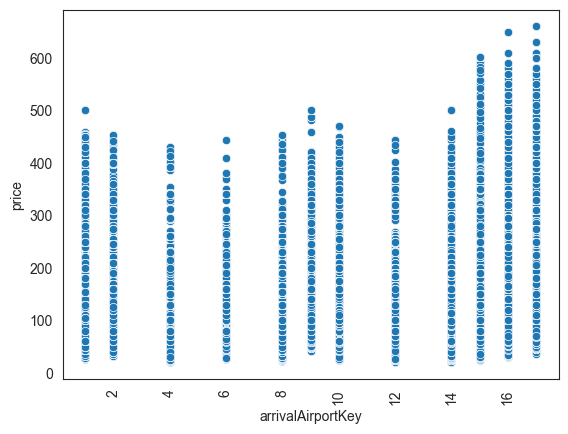

De correlatie tussen arrivalAirportKey en price is:  0.18852493219829


,airport_key,airline_key,flight_key,numberOfStops,date_key,day_of_week,day_of_month,day_of_year,year,numberOfQuarter,...,flightfare_key,flight_key,airline_key,depatureAirportKey,arrivalAirportKey,scrapeDateKey,departureDateKey,arrivalDateKey,availableSeats,price
airport_key,1.000000,0.078316,0.384524,0.131228,-0.044019,-0.005805,0.002044,-0.043586,NaN,-0.057493,...,-0.002175,0.384524,0.078316,1.000000,0.040788,-0.002192,-0.044019,-0.044019,-0.109445,-0.031373
airline_key,0.078316,1.000000,0.902726,0.225406,0.033641,0.007564,-0.010884,0.032004,NaN,0.043278,...,-0.000128,0.902726,1.000000,0.078316,0.045527,0.008346,0.033641,0.033641,-0.373455,0.478325
flight_key,0.384524,0.902726,1.000000,0.245084,0.041703,0.020840,-0.007311,0.040642,NaN,0.043951,...,0.000835,1.000000,0.902726,0.384524,0.264793,0.008777,0.041703,0.041703,-0.327845,0.441412
numberOfStops,0.131228,0.225406,0.245084,1.000000,-0.024772,-0.005157,0.002161,-0.024352,NaN,-0.038165,...,0.000942,0.245084,0.225406,0.131228,0.020621,0.006320,-0.024772,-0.024772,-0.097849,0.055788
date_key,-0.044019,0.033641,0.041703,-0.024772,1.000000,-0.007438,-0.079615,0.990540,NaN,0.860564,...,0.000089,0.041703,0.033641,-0.044019,0.009273,0.089322,1.000000,1.000000,-0.117841,-0.134114
day_of_week,-0.005805,0.007564,0.020840,-0.005157,-0.007438,1.000000,0.014556,-0.005060,NaN,-0.041432,...,0.000675,0.020840,0.007564,-0.005805,0.026052,-0.001827,-0.007438,-0.007438,0.014615,0.071662
day_of_month,0.002044,-0.010884,-0.007311,0.002161,-0.079615,0.014556,1.000000,0.057789,NaN,-0.122331,...,0.001304,-0.007311,-0.010884,0.002044,0.000158,0.007169,-0.079615,-0.079615,-0.000776,-0.068147
day_of_year,-0.043586,0.032004,0.040642,-0.024352,0.990540,-0.005060,0.057789,1.000000,NaN,0.842447,...,0.000266,0.040642,0.032004,-0.043586,0.009248,0.090121,0.990540,0.990540,-0.118003,-0.145808
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numberOfQuarter,-0.057493,0.043278,0.043951,-0.038165,0.860564,-0.041432,-0.122331,0.842447,NaN,1.000000,...,-0.000055,0.043951,0.043278,-0.057493,0.011514,0.064174,0.860564,0.860564,-0.091017,0.080658


In [14]:
# read the data
data = df

# switch the arrivalAirportKey back to the original values
data['arrivalAirportKey'] = data['arrivalAirportKey'].apply(switch_arrival_airport_key_back)

# make a plot
sns.scatterplot(data=data, x="arrivalAirportKey", y="price")
plt.xticks(rotation=90)
plt.show()

# calculate the correlation coefficient
data['arrivalAirportKey'] = data['arrivalAirportKey'].astype('int64')
corr = data['arrivalAirportKey'].corr(data['price'])
print("De correlatie tussen arrivalAirportKey en price is: ", corr)

# create a correlation matrix
corrMatrix = data.corr()
pd.DataFrame(corrMatrix)

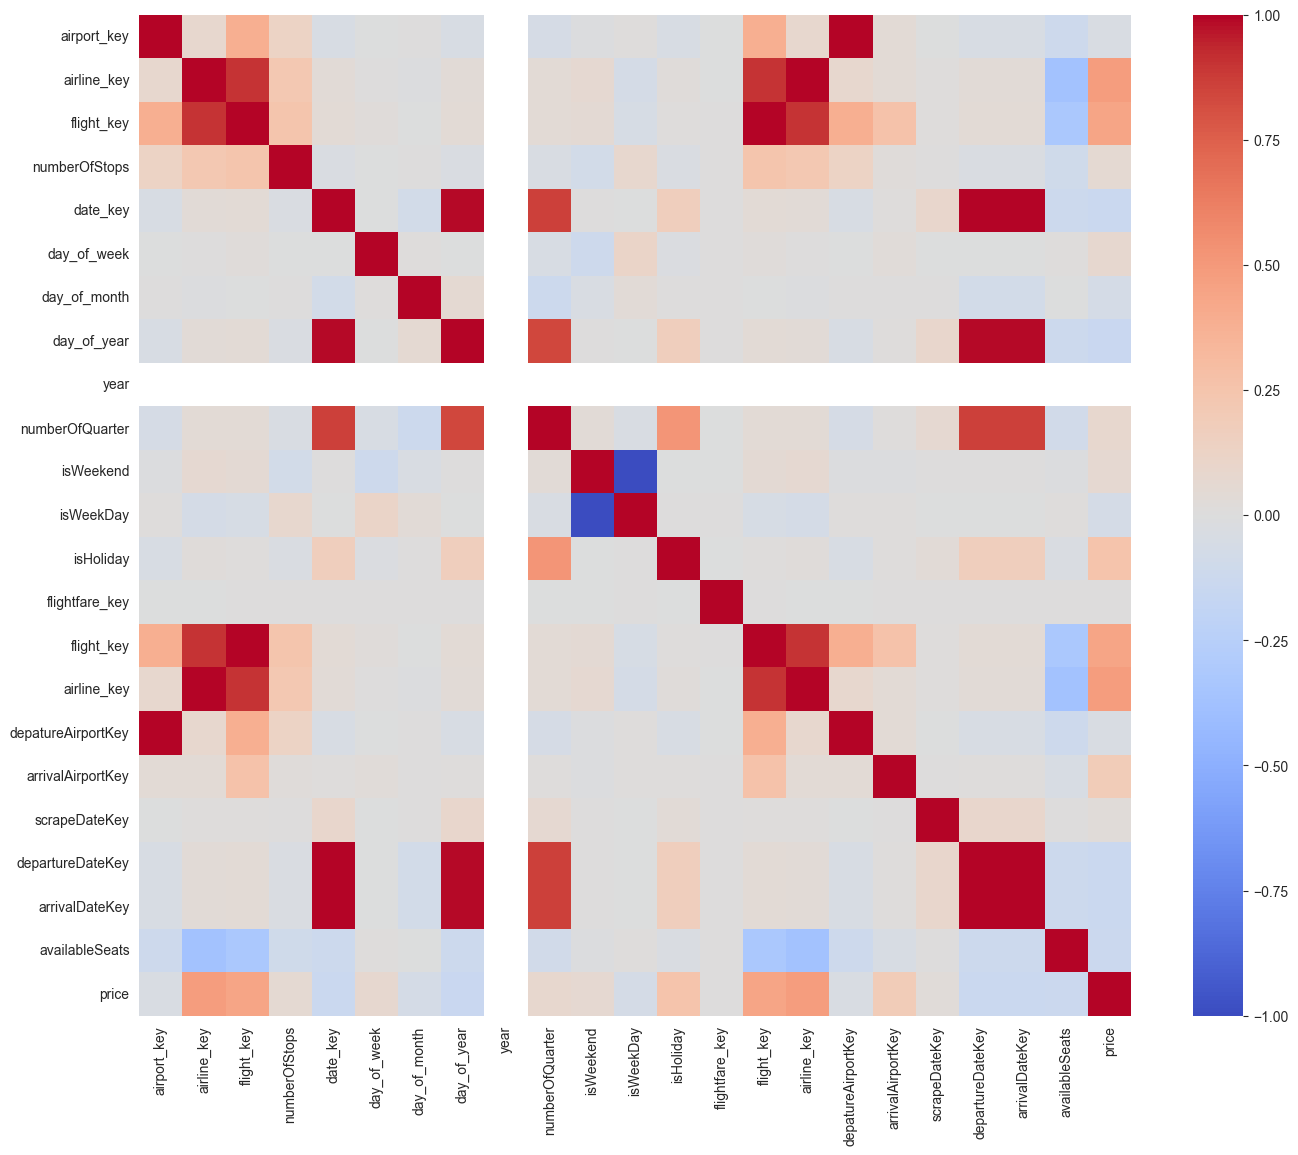

In [15]:
# plot the correlation matrix
plt.figure(figsize=(16, 13))
sns.heatmap(corrMatrix, annot=False, cmap="coolwarm")
plt.show()

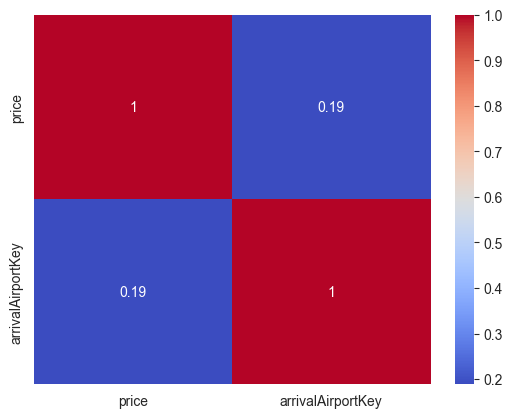

In [16]:
# select the columns to include in the new correlation matrix
cols = ['price', 'arrivalAirportKey']

# create a new correlation matrix
corrMatrixPricaAirport = df[cols].corr()

# plot the new correlation matrix
sns.heatmap(corrMatrixPricaAirport, annot=True, cmap="coolwarm")
plt.show()

### 8) Zijn de prijzen gerelateerd aan Belgische vakantieperiodes?

In [17]:
# read the data
data = df

# maak variabele aan met het juiste data type
isHoliday = data["isHoliday"].astype(str)

# bereken de gemiddelde prijzen voor vakantieperiode ja of nee
vakantie_gemiddelde = data.groupby("isHoliday")["price"].mean()

# print de gemiddelde prijs per vakantie binnen en buiten de vakantieperiodes
print("Gemiddelde prijzen per Vakantie:\n", vakantie_gemiddelde)

Gemiddelde prijzen per Vakantie:
 isHoliday
0    145.211986
1    187.079647
Name: price, dtype: float64


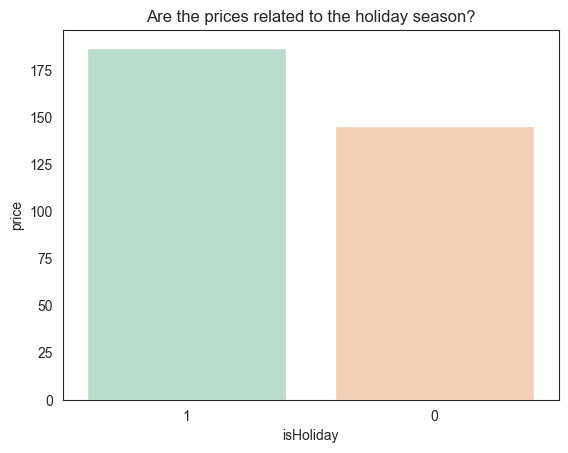

In [18]:
# create a barplot
sns.barplot(x=isHoliday, y="price", data=data, palette="Pastel2", ci=None)
plt.title("Are the prices related to the holiday season?")
plt.show()

### 9) Kan je de prijsstrategie afleiden? (Invloed van aantal dagen voor vertrek, invloed van beschikbaarheid)

**PowerBI** &nbsp;&nbsp; *Vraag 9*, *Vraag 9 deel 2*

### 10) Is er een link tussen prijs en afstand (en duration)? Bijvoorbeeld Tenerife is anderhalf uur verder dan Alicante.

**PowerBI** &nbsp;&nbsp; *Vraag 10*

### 11) Is er een link tussen prijs en land? Zijn sommige landen opvallend duurder (en kan dit niet verklaard worden door de extra afstand)

**PowerBI** &nbsp;&nbsp; *Vraag 11*

### 12) Hoeveel dagen voor vertrek is een vlucht volgeboekt? Zijn er bestemmingen waarbij de vluchten bijna volgeboekt zijn?

**PowerBI** &nbsp;&nbsp; *Vraag 12p2*

In [19]:
# read the data
data = df

# create a new column 'departureDate' with the correct data type
data['departureDate'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# create a new column 'arrivalAirport' with the name of the arrival airport
data['arrivalAirport'] = data['arrivalAirportKey'].apply(switch_arrival_airport_key)

# create function to calculate the differnce in days if there are no seats available
def calc_date_diff(row):
    if row['availableSeats'] == 0:
        today = datetime.date.today()
        return (row['departureDate'] - today).days
    else:
        return "seats available"
    


# apply the function to the dataframe
data['countOfDaysBeforeMaxCapacity'] = data.apply(calc_date_diff, axis=1)

# select the columns to include
cols = ['flight_key', 'depatureAirportKey', 'airport_name', 'arrivalAirportKey', 'arrivalAirport', 'departureDateKey', 'departureDate', 'arrivalDateKey', 'availableSeats', 'price', 'countOfDaysBeforeMaxCapacity']

# create a new dataframe with the selected columns
data = data[cols]

# print the dataframe
data

,flight_key,flight_key,depatureAirportKey,airport_name,arrivalAirportKey,arrivalAirport,departureDateKey,departureDate,arrivalDateKey,availableSeats,price,countOfDaysBeforeMaxCapacity
0,1,1,5,Brussels Airline,1,Malaga,20230416,2023-04-16,20230416,2,103.51,seats available
1,1,1,5,Brussels Airline,1,Malaga,20230416,2023-04-16,20230416,3,127.99,seats available
2,1,1,5,Brussels Airline,1,Malaga,20230416,2023-04-16,20230416,3,136.55,seats available
3,1,1,5,Brussels Airline,1,Malaga,20230416,2023-04-16,20230416,5,130.13,seats available
4,1,1,5,Brussels Airline,1,Malaga,20230416,2023-04-16,20230416,5,106.77,seats available
...,...,...,...,...,...,...,...,...,...,...,...,...
182280,5593,5593,13,Oostende-Brugge International Airport,17,Tenerife,20231004,2023-10-04,20231004,-1,249.99,seats available
182281,5593,5593,13,Oostende-Brugge International Airport,17,Tenerife,20231004,2023-10-04,20231004,-1,249.99,seats available
182282,5593,5593,13,Oostende-Brugge International Airport,17,Tenerife,20231004,2023-10-04,20231004,-1,249.99,seats available
182283,5593,5593,13,Oostende-Brugge International Airport,17,Tenerife,20231004,2023-10-04,20231004,-1,249.99,seats available


### 13) Hoeveel procent van de vluchten zijn volgeboekt? / Hoeveel plaatsen zijn er nog vrij 5 dagen voor vertrek?

#### Hoeveel procent van de vluchten zijn volgeboekt?

In [20]:
# read the data
data = df

# iterate over the data and add to array
dataArr = []
for i in range(len(data)):
    dataArr.append(data.iloc[i])

# get the total amount of flights
total_flights = len(dataArr)

# get the total amount of flights that are full
full_flights = 0
for flight in dataArr:
    if flight['availableSeats'] == 0:
        full_flights += 1

# calculate the percentage of full flights
percentage_full_flights = (full_flights / total_flights) * 100

# print the percentage of full flights
print(f"{round(percentage_full_flights, 2)} % of all flights are full.")

0.0 % of all flights are full.


#### Hoeveel plaatsen zijn er nog vrij 5 dagen voor vertrek?

##### Functie voor de available seats op te vragen voor een bepaalde departure date

In [21]:
def get_available_seats(data, departure_date, flightkey):
    # set the scrapeDate to the given departure date minus 5 days
    five_days_before_departure = departure_date - 5

    # get the subset of flights for the given departure date
    subset = data[(data['scrapeDateKey'] == five_days_before_departure) & (data['flightnumber'] == flightkey) & (data['departureDateKey'] == departure_date)]

    # if the subset is empty, return -2
    if subset.empty:
        return -2
    
    # if the available seats for the flight is equal to -1, set the available seats to -1
    if subset['availableSeats'].iloc[0] == -1:
        return -1

    # get the available seats for the given departure date out of the subset
    available_seats = subset['availableSeats'].iloc[0]
    
    # return the availble seats
    return available_seats

##### CSV met de data van de available seats op 5 dagen voor vertrek (incl. enkele andere nuttige data)

In [22]:
# give the departure date as input + calculate the 5 days before departure date
departureDate = 20230425
five_days_before_departure = departureDate - 5

# read the data with the given departure date and the 5 days before departure date
data = df[df['departureDateKey'].isin([five_days_before_departure, departureDate])]

# get the available seats for each flight with the function
available_seats = []
for flight in data.itertuples():
    available_seats.append(get_available_seats(data, departureDate, flight.flightnumber))

# add the available seats to the dataframe
data['available_seats_fiveDays'] = available_seats

# add the switched arrival airport name to the dataframe
data['arrivalAirportKey'] = data['arrivalAirportKey'].apply(switch_arrival_airport_key)

# only add the flights where the scrapeDateKey is equal to the given departure date minus 5 days
data1 = data[(data['scrapeDateKey'].values == departureDate - 5) & (data['departureDateKey'].values == departureDate)]

# write to csv
csv = data1[['flightnumber', 'airline_name', 'arrivalAirportKey', 'scrapeDateKey', 'departureDateKey', 'departureTime', 'arrivalTime', 'available_seats_fiveDays']].to_csv('availableSeats5Days.csv', index=False)

# drop the duplicates in the csv
availablecsv = pd.read_csv('availableSeats5Days.csv')
availablecsv = availablecsv.drop_duplicates(keep='last')
availablecsv.to_csv('availableSeats5Days.csv', index=False)

##### Plot met de available seats op 5 dagen voor vertrek per vlucht

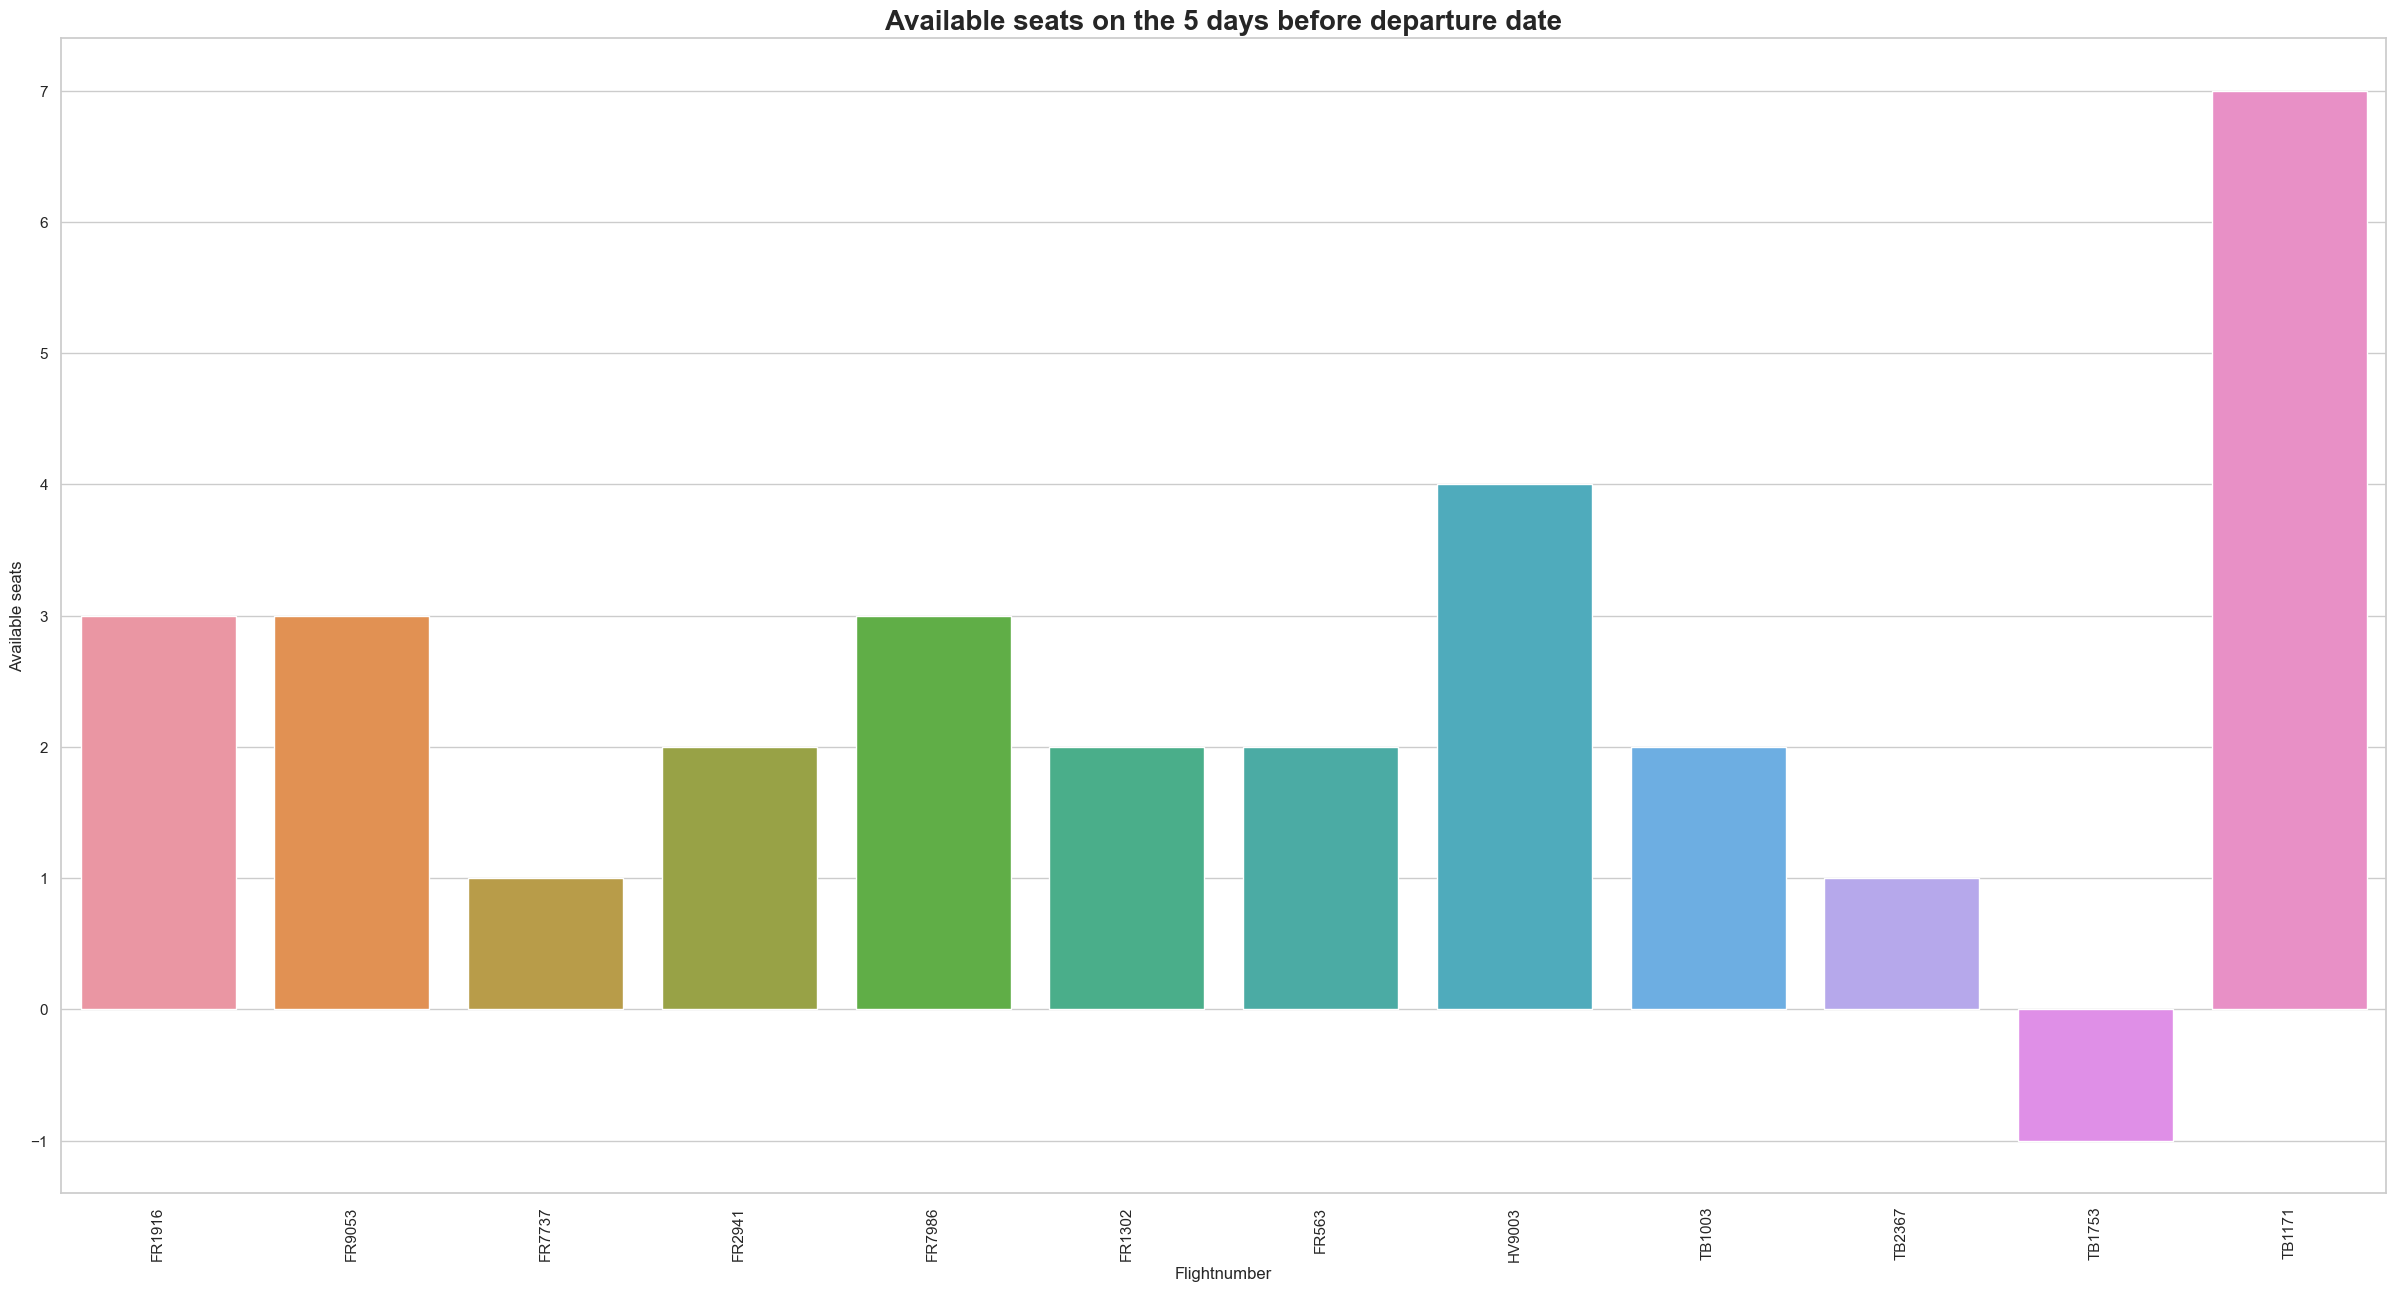

In [23]:
plt.figure(figsize=(30, 15))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="flightnumber", y="available_seats_fiveDays", data=data1)
ax.set_title('Available seats on the 5 days before departure date', fontsize=20, fontweight='bold')
ax.set_xlabel('Flightnumber')
ax.set_ylabel('Available seats')
plt.xticks(rotation=90)
y = data1['available_seats_fiveDays']
plt.yticks(range(int(min(y)), int(max(y)) + 1, 1))
plt.show()

### 14) Plot het verband tussen de prijs en het aantal dagen voor vertrek voor Ryanair voor de afgelopen maand. Maak gebruik van regressie om de prijzen te voorspellen voor de volgende maand.

#### Plot het verband tussen de prijs en het aantal dagen voor vertrek voor Ryanair voor de afgelopen maand.

Text(0, 0.5, 'Prijs (€)')

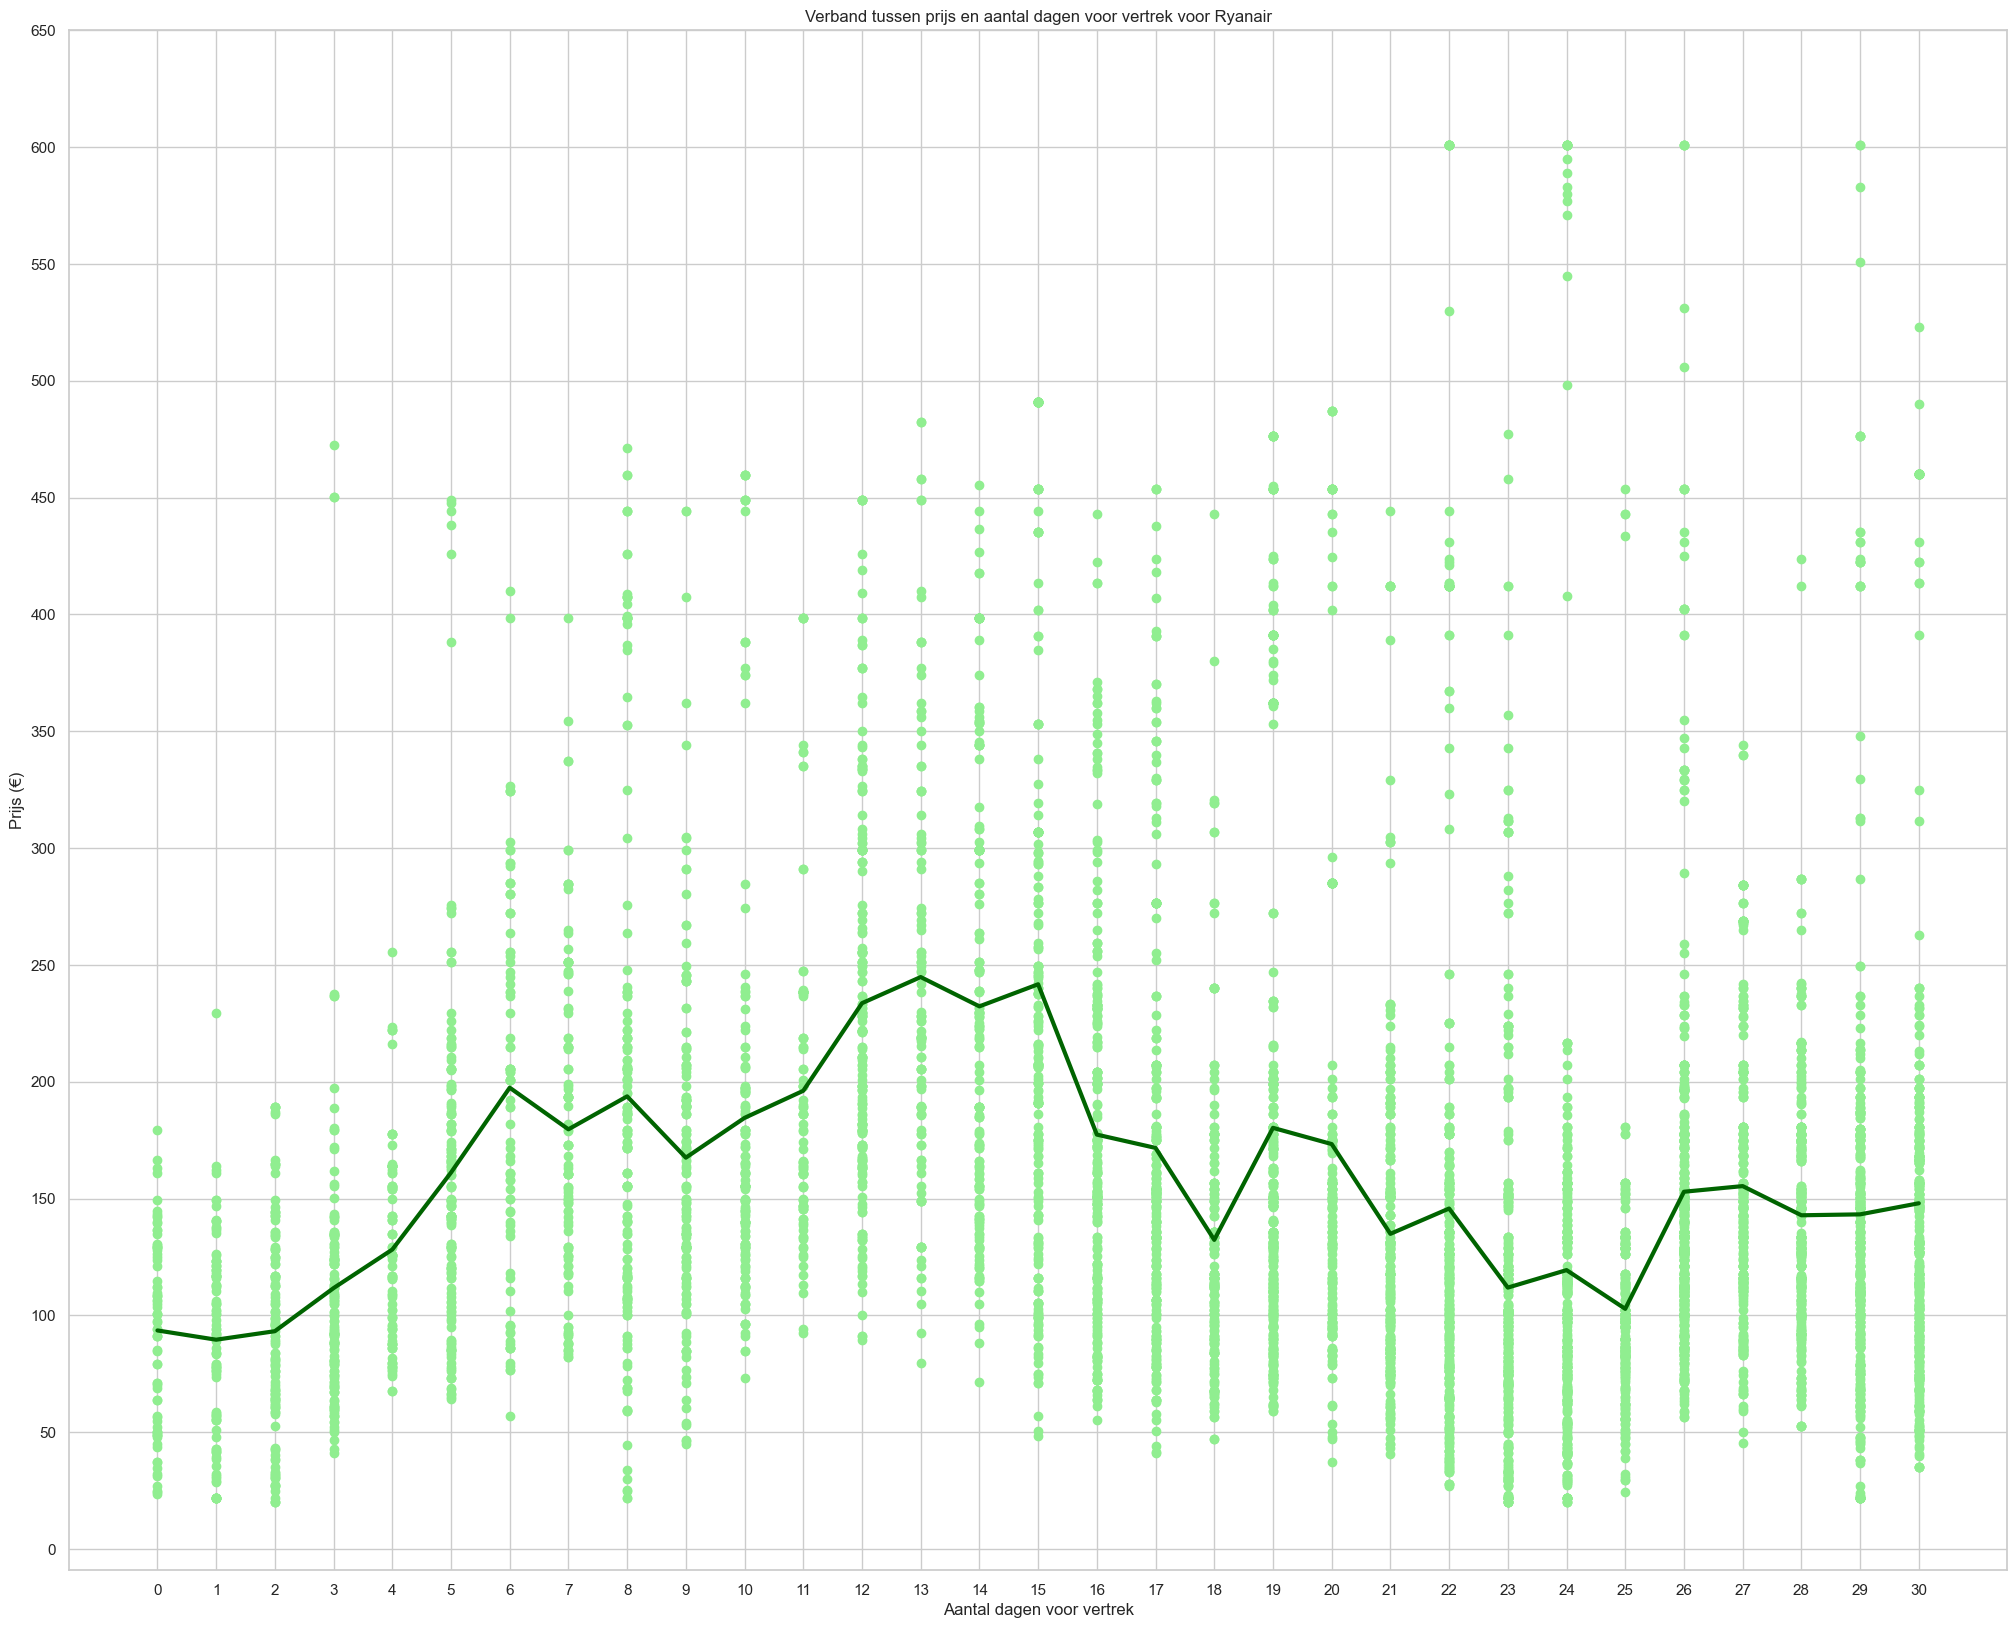

In [24]:
# read the data
data = df

# filter the data for Ryanair
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# add new column for days before departure
data['days_before_departure'] = (data['departure_date'] - data['departure_date'].min()).dt.days

# previous month with datetime
previous_month = datetime.datetime.now() - datetime.timedelta(days=31)

# today with datetime
today = datetime.datetime.now()

# filter the data for the last month ()
data = data[(data['departure_date'] >= previous_month) & (data['departure_date'] <= today)]

# reshape the data
reshaped = (data['departure_date'] - previous_month).dt.days.values.reshape(-1, 1)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# select the mean price for each day before departure
shifted = data.groupby('days_before_departure')['price'].mean()

# reshape shifted
shifted = shifted.values.reshape(-1, 1)

# plot the results
sns.set_style('whitegrid')
plt.figure(figsize=(25, 20))
plt.plot(reshaped, data['price'], 'o', color='lightgreen')
plt.plot(shifted, color='darkgreen', linewidth=3)
plt.title('Verband tussen prijs en aantal dagen voor vertrek voor Ryanair')
plt.xticks(range(0, 31, 1))
plt.xlabel('Aantal dagen voor vertrek')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')

#### Maak gebruik van regressie om de prijzen te voorspellen voor de volgende maand.

##### Linear Regression

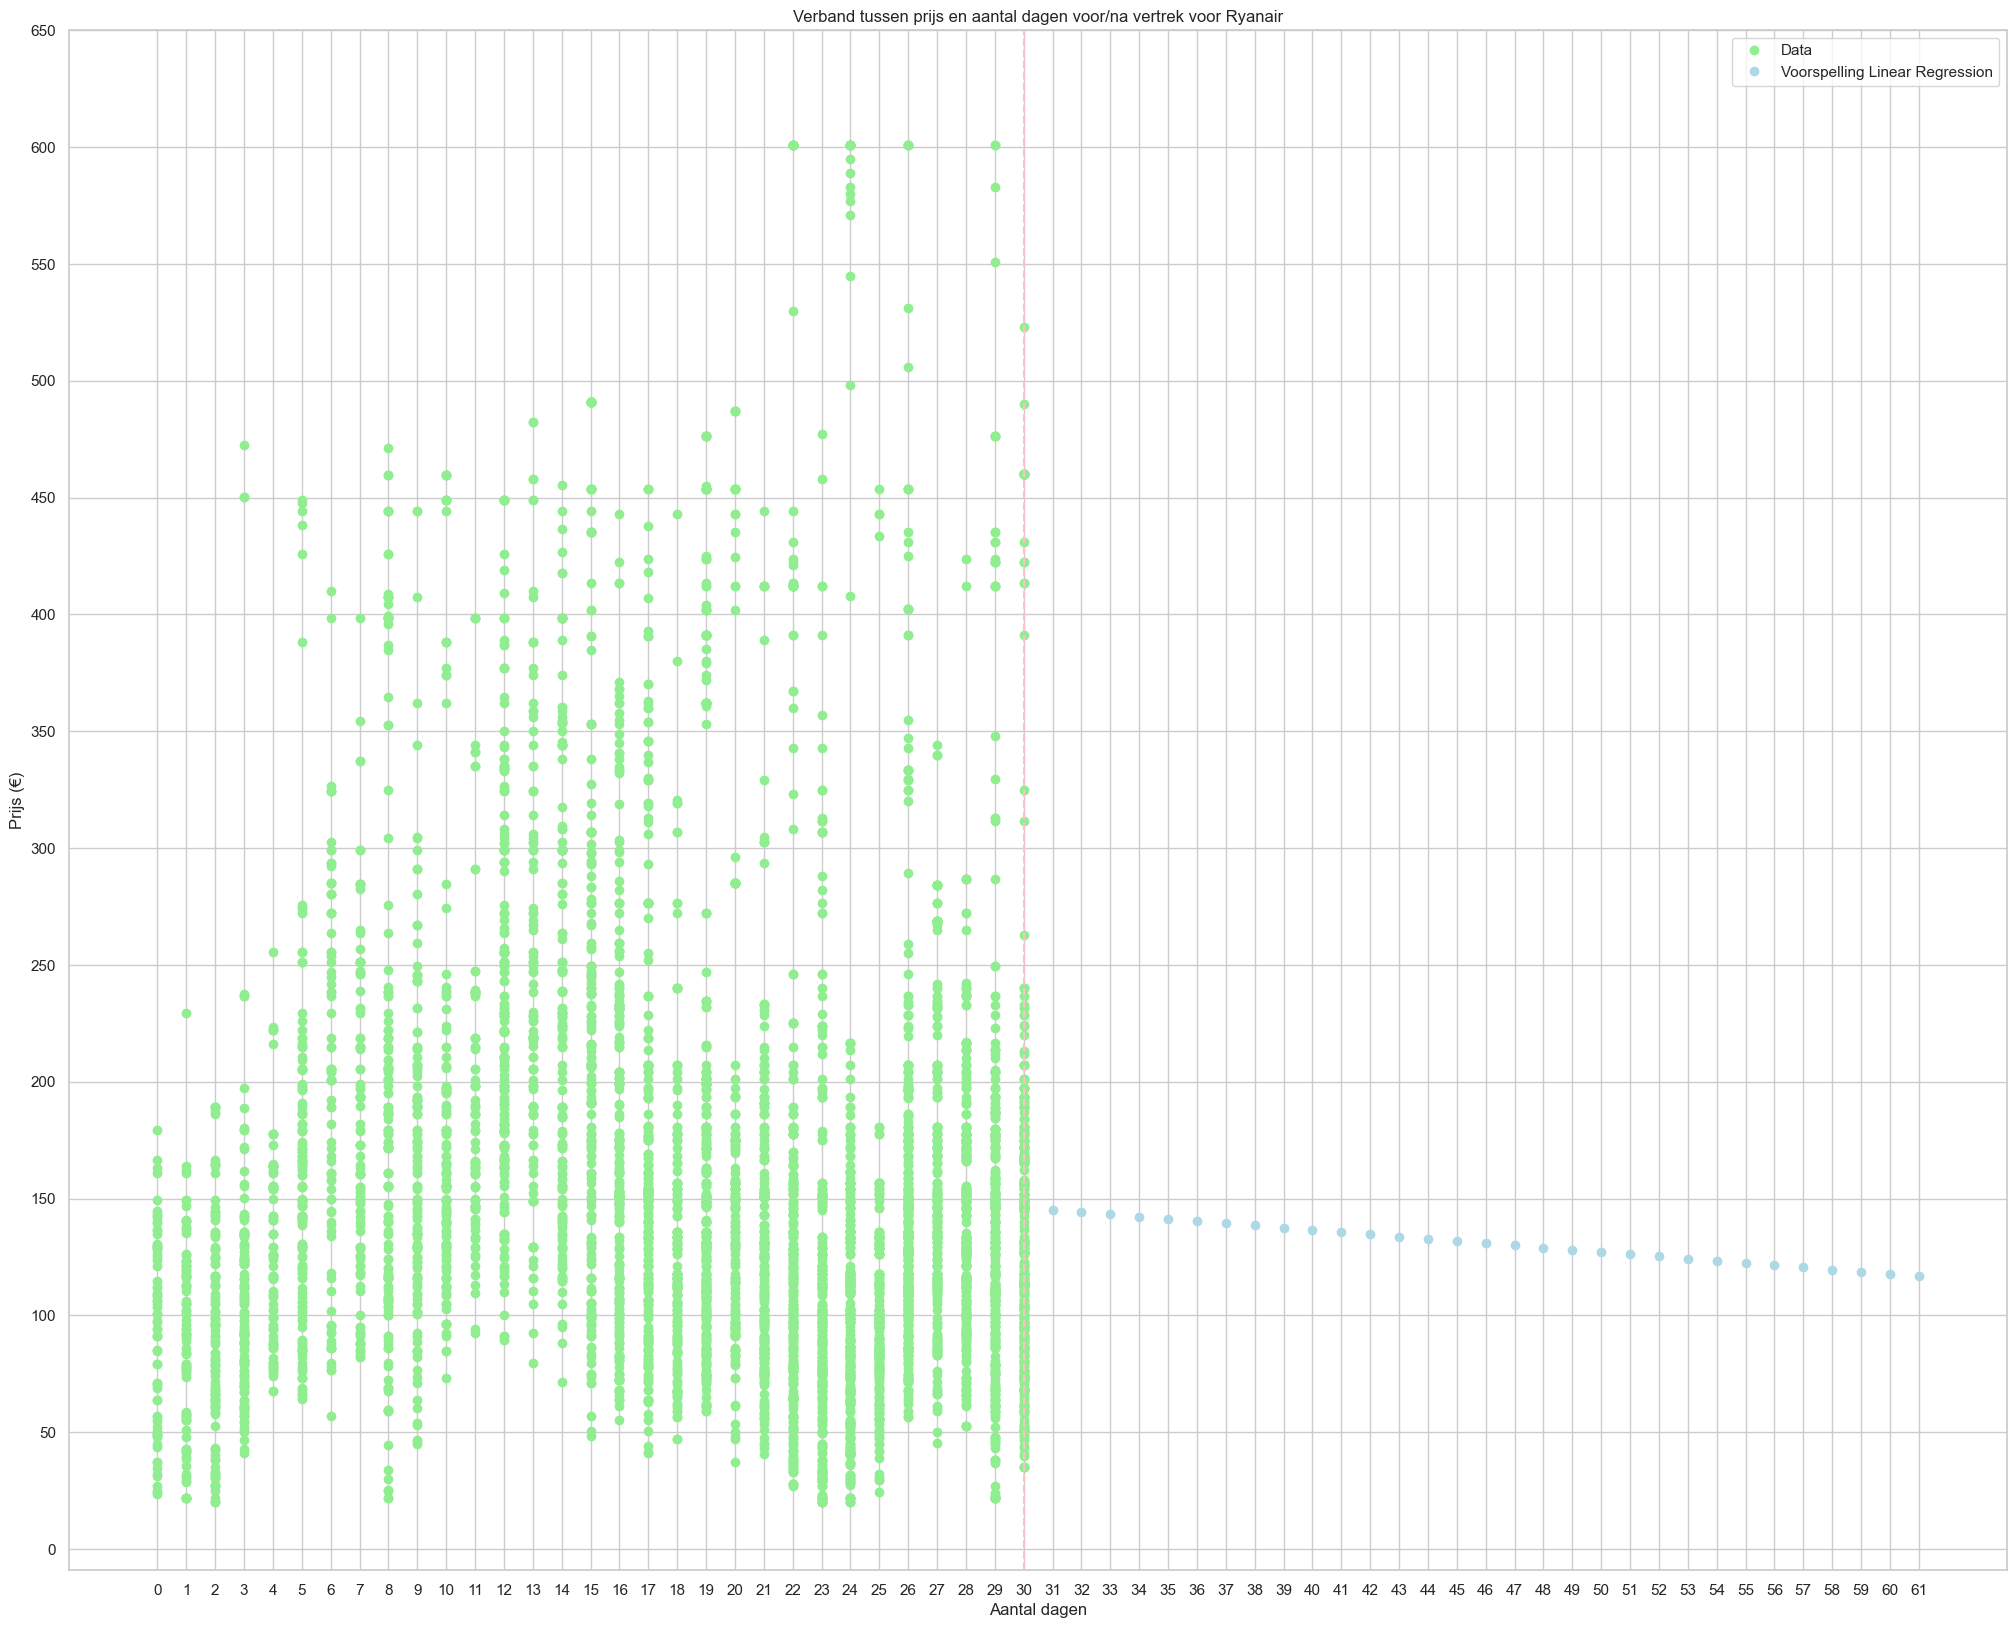

Accuracy score: 0.698297201035647 %
MSE: 8857.06969105234


In [25]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create linear regression model
lr = LinearRegression(n_jobs=-1)

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
lr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_lr = lr.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_lr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling Linear Regression'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {lr.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, lr.predict(X_train))}")

##### Random Forest Regression

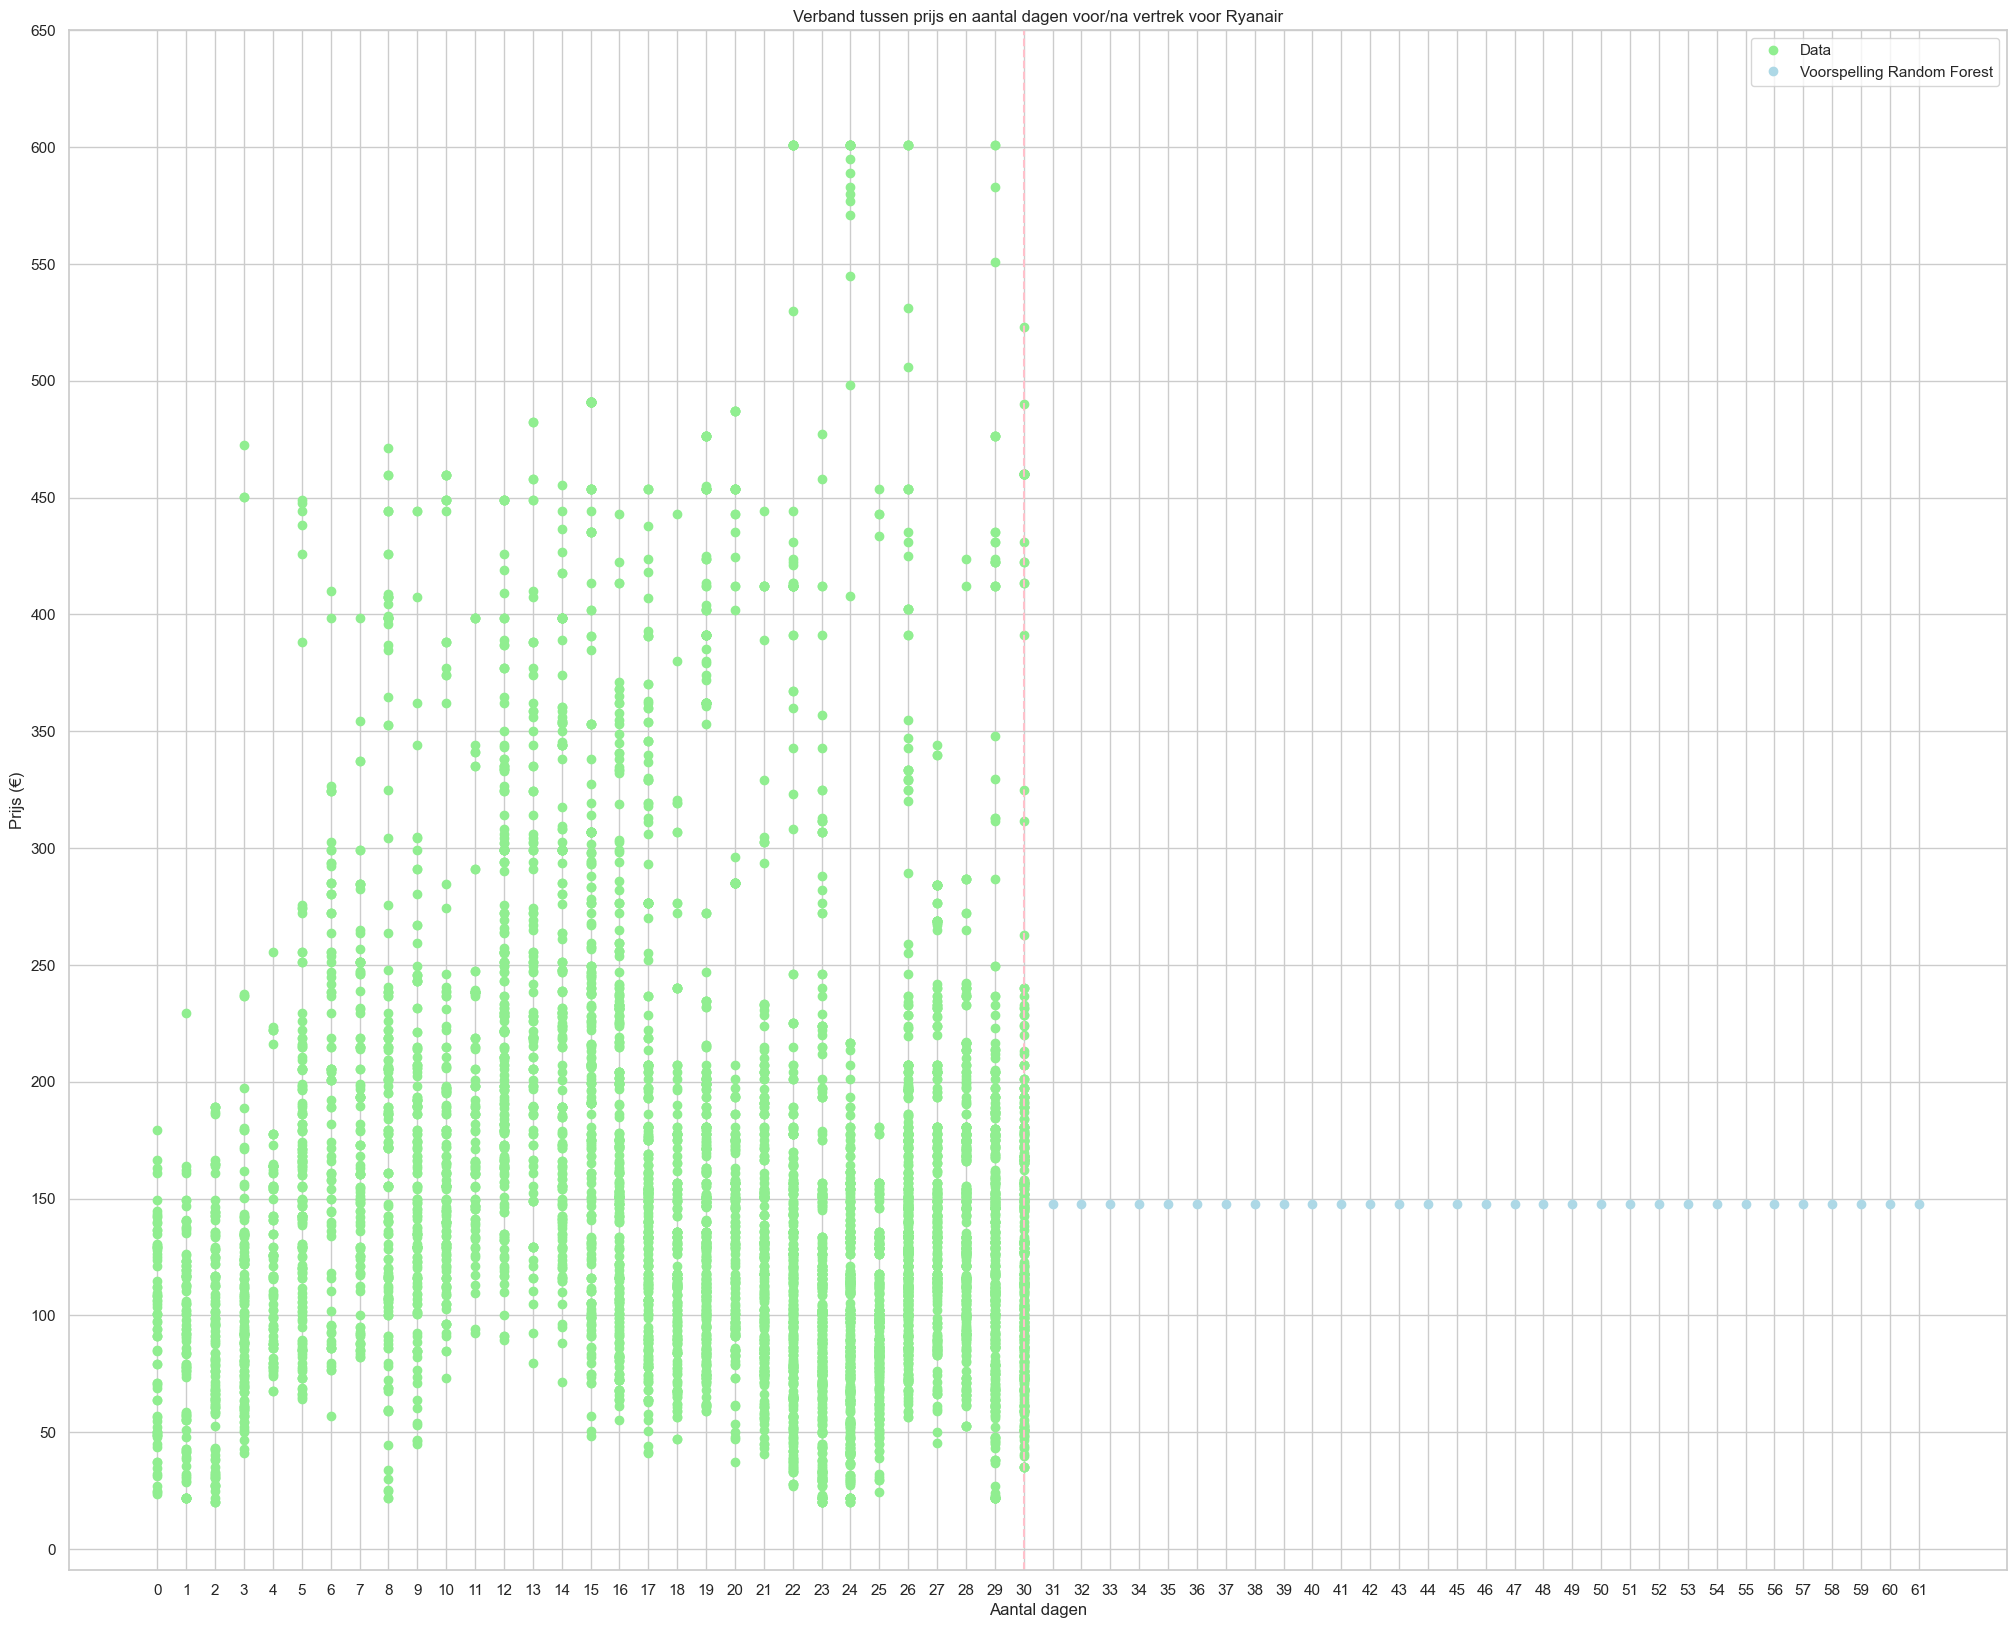

Accuracy score: 16.096142537884027 %
MSE: 7483.6814671201555


In [26]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create random forest regression model
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
rfr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_rfr = rfr.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_rfr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling Random Forest'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {rfr.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, rfr.predict(X_train))}")

##### Hard Voting

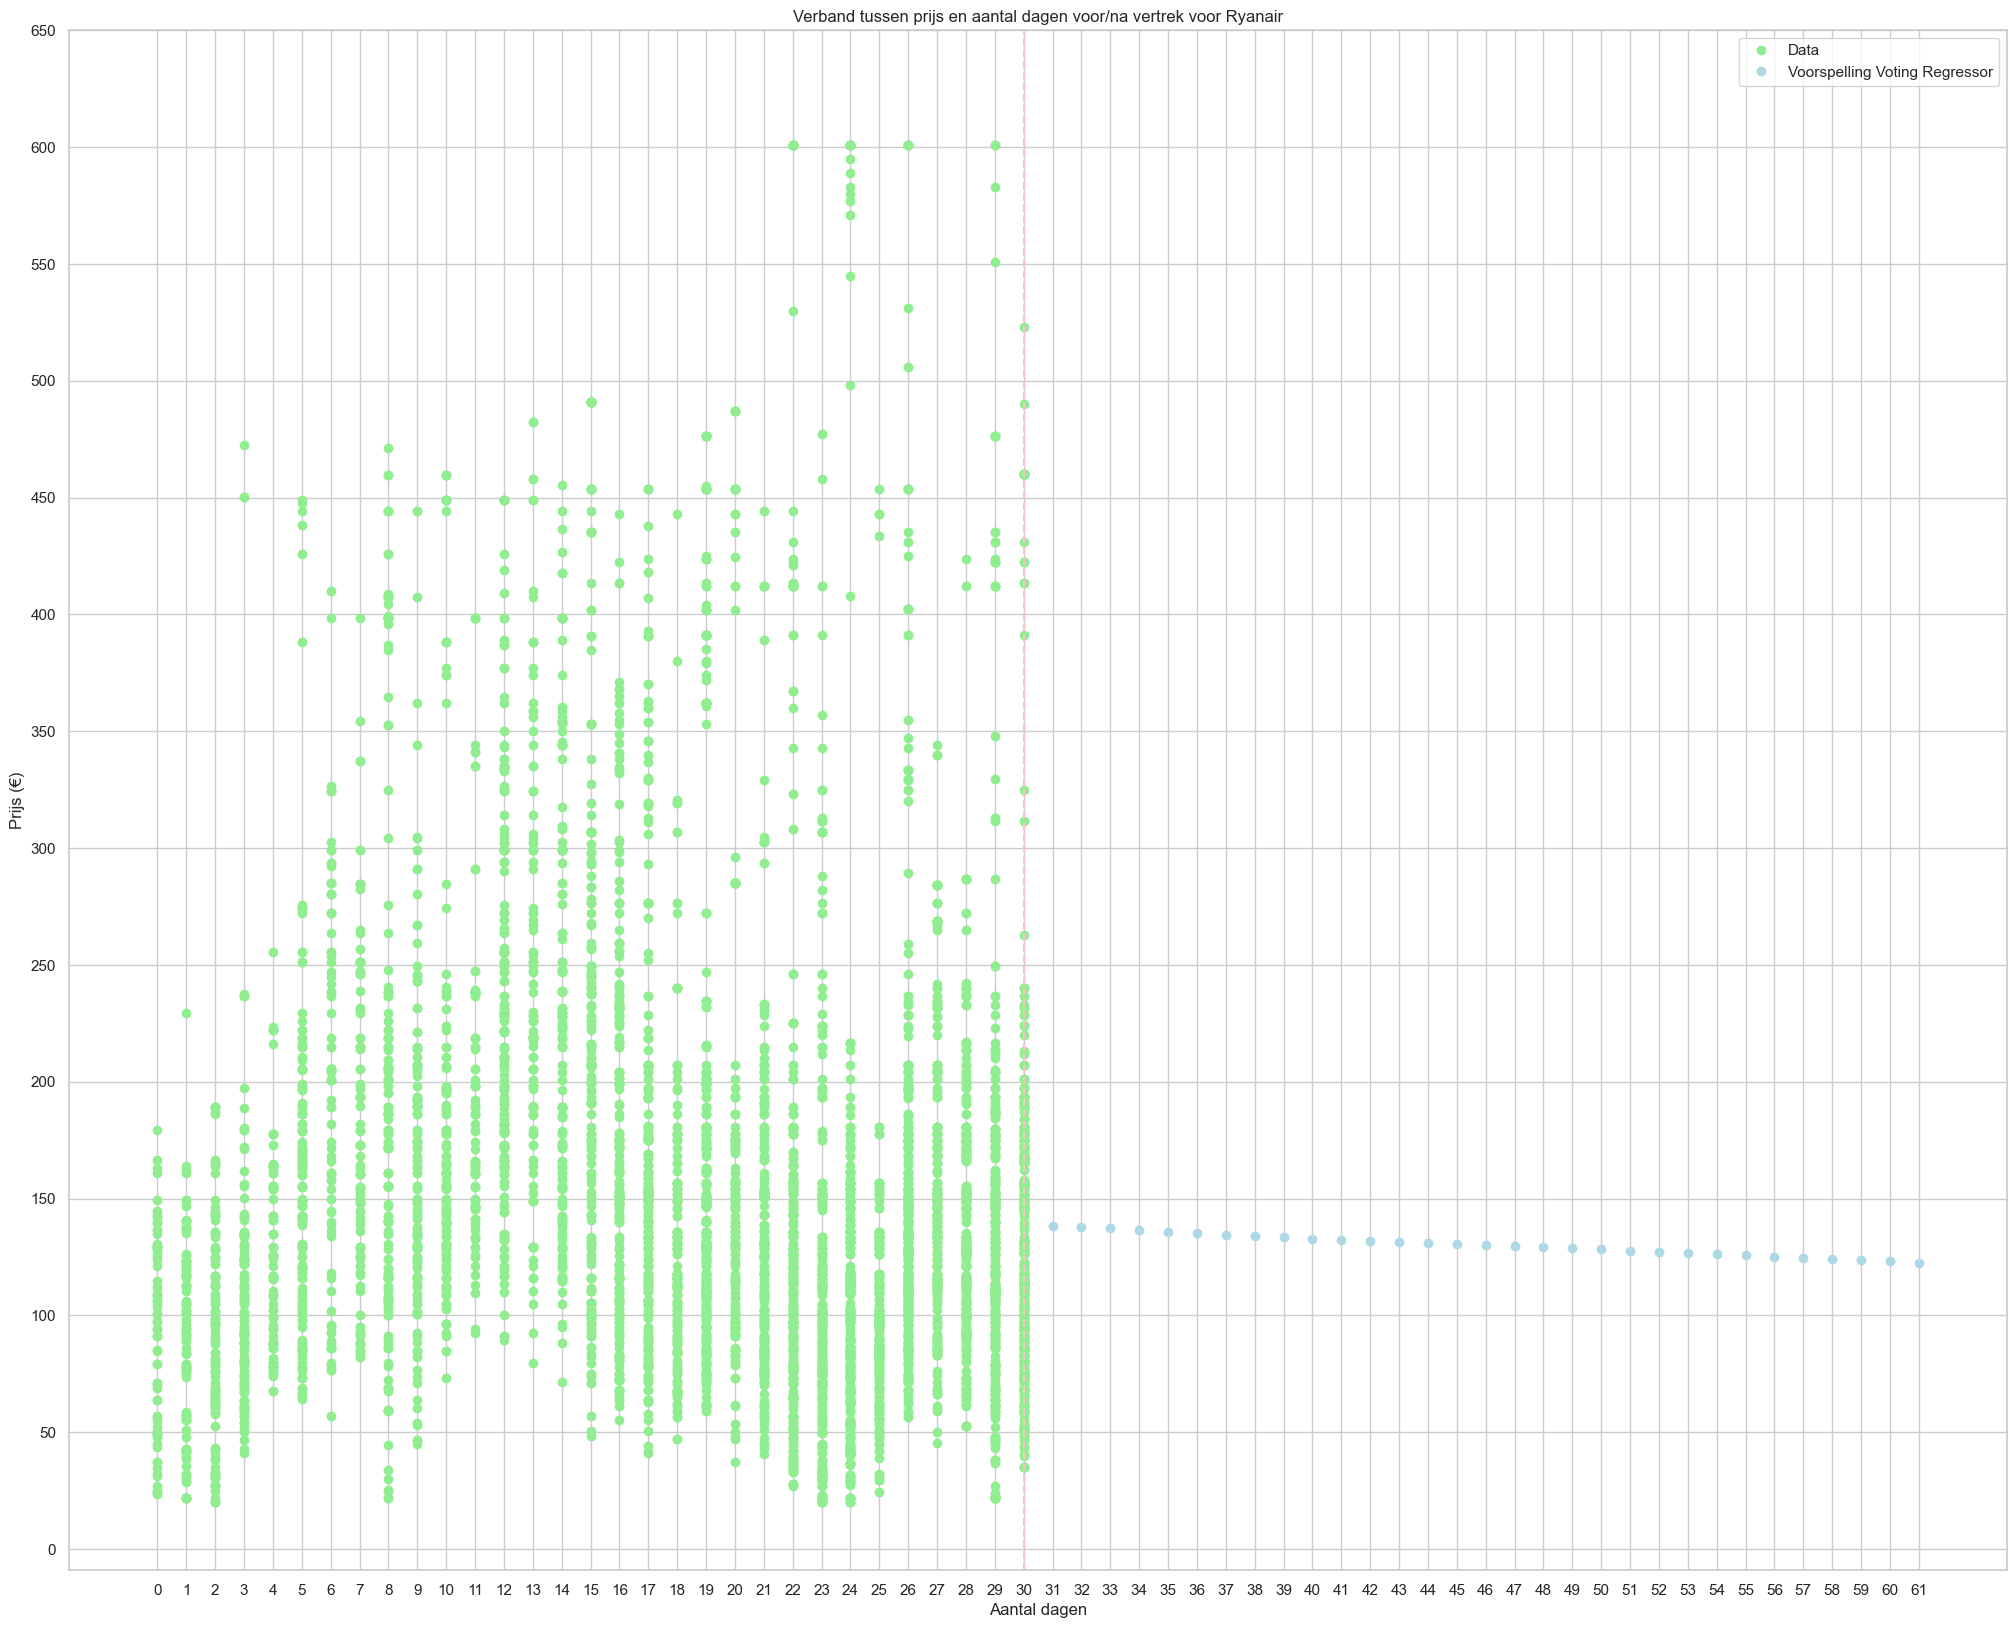

Accuracy score: 12.90357974655717 %
MSE: 7768.4374213366555


In [27]:
# create the regression models
lr = LinearRegression(n_jobs=-1)
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
gb = GradientBoostingRegressor(random_state=42)
dt = DecisionTreeRegressor(random_state=42)
sgd = SGDRegressor(random_state=42)
svr = SVR()

# create the voting regressor
vr = VotingRegressor([('lr', lr), ('rf', rf), ('gb', gb), ('dt', dt), ('sgd', sgd), ('svr', svr)])

# fit the model
vr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_vr = vr.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_vr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling Voting Regressor'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {vr.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, vr.predict(X_train))}")

##### Decision Tree Regressor

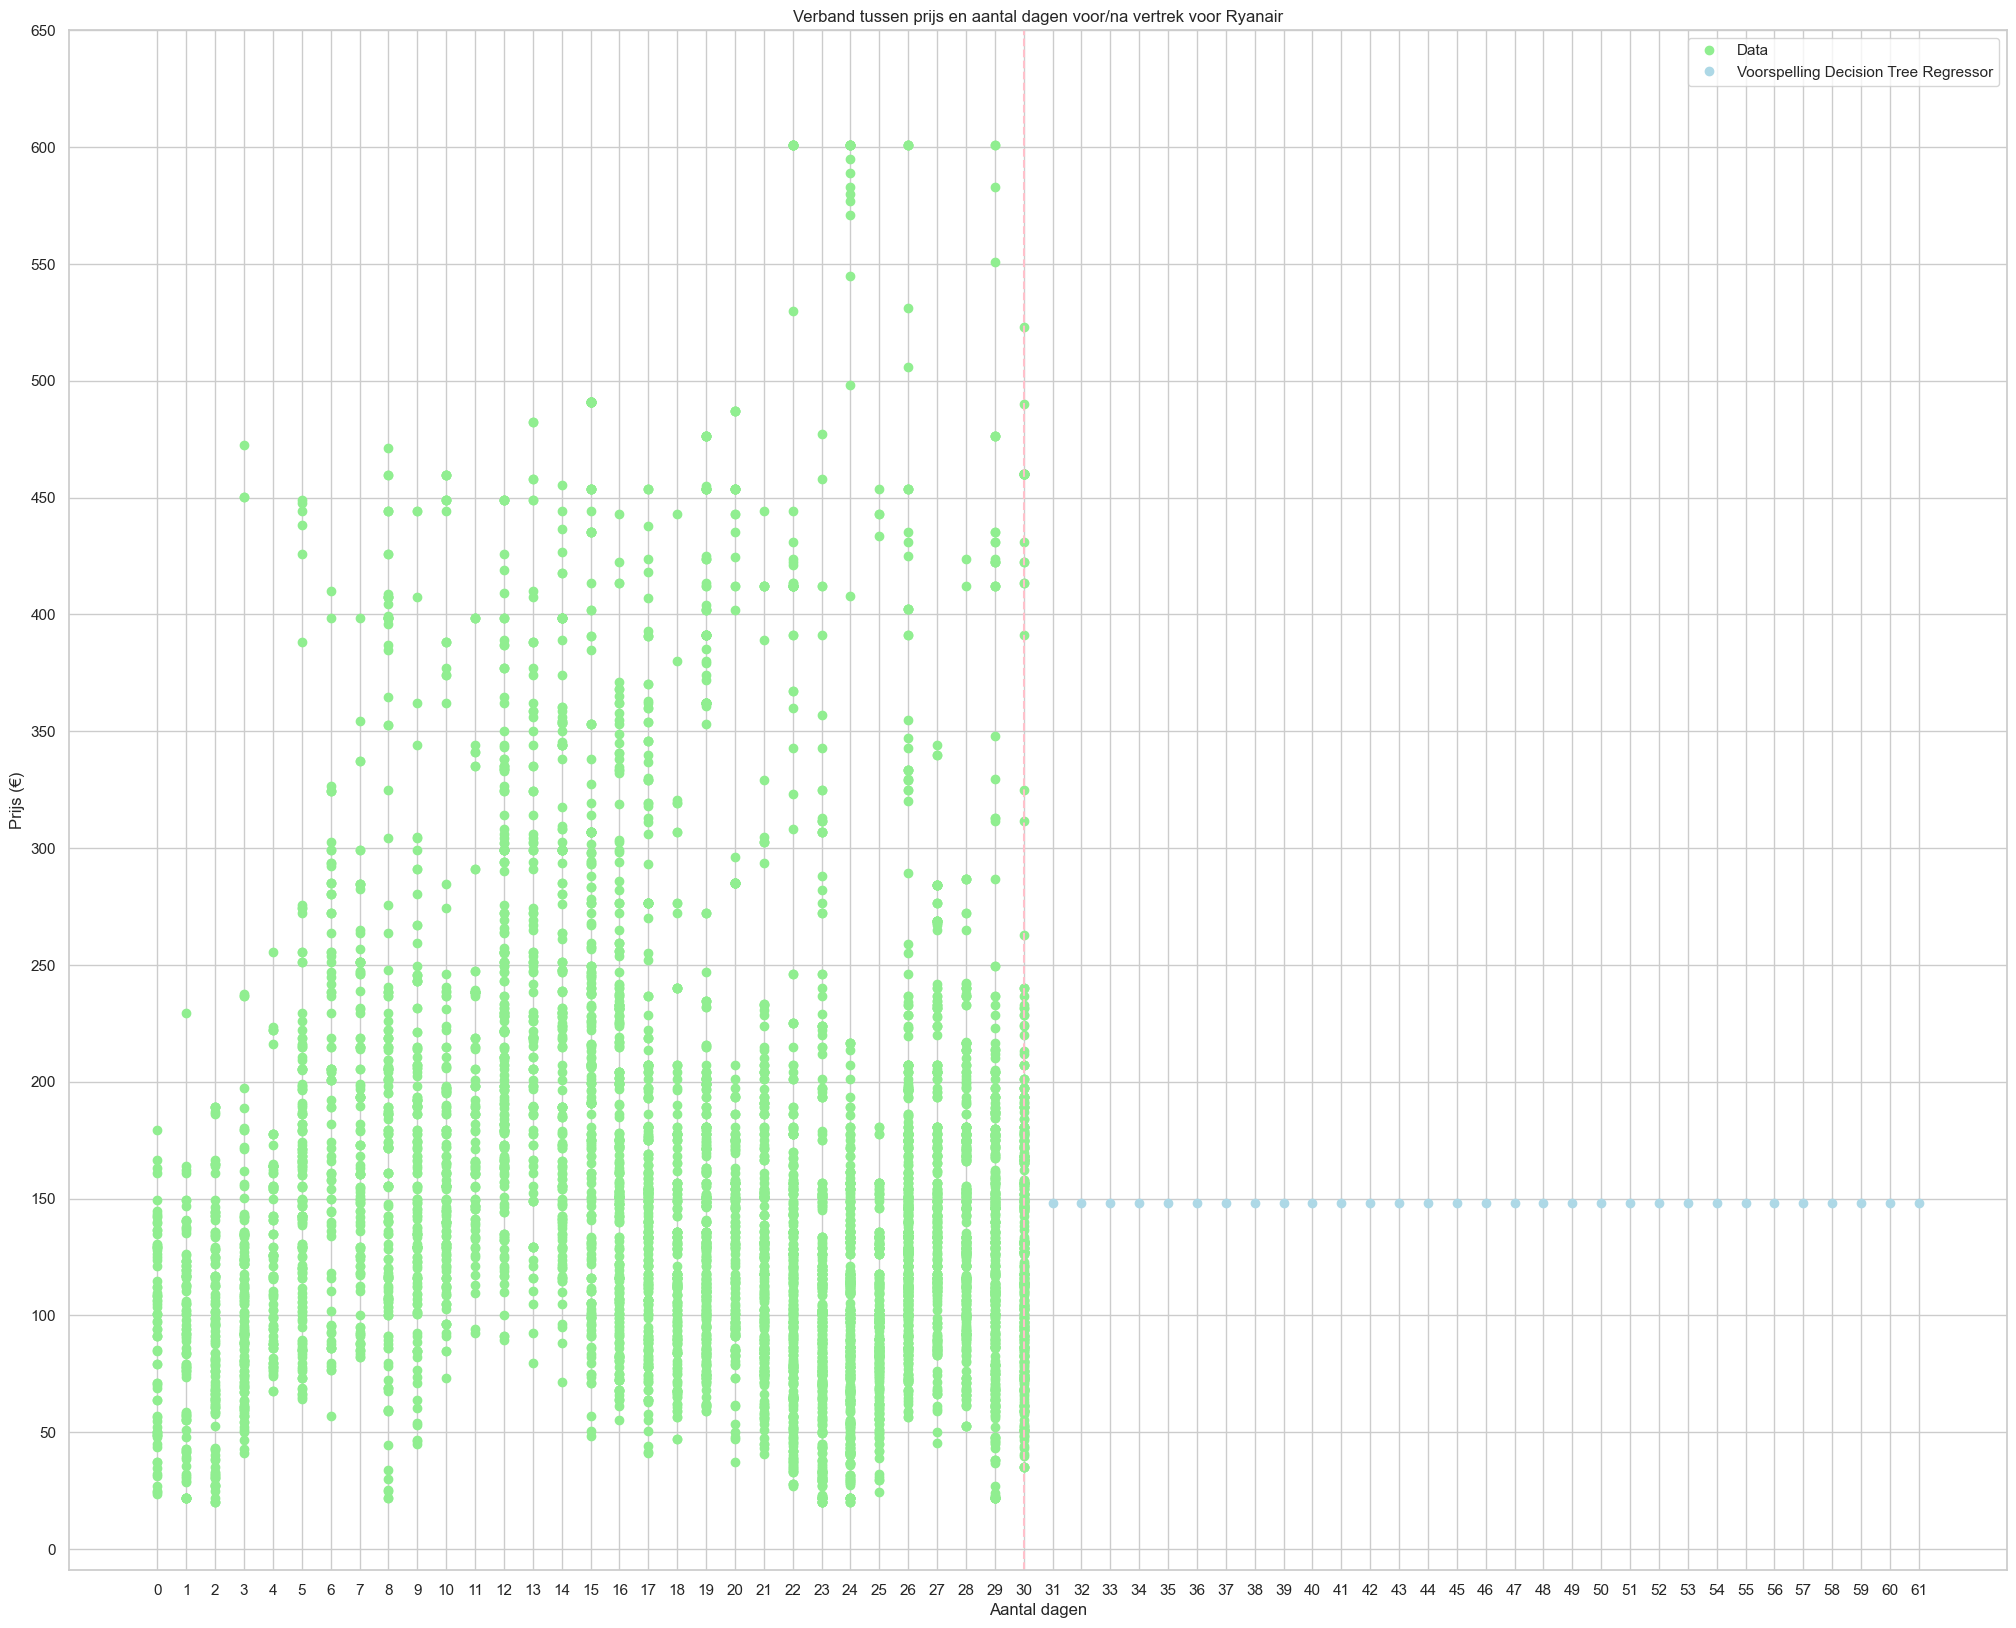

Accuracy score: 16.099823032582872 %
MSE: 7483.353190795313


In [28]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create decision tree regression model
dtr = DecisionTreeRegressor(random_state=42)

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
dtr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_dtr = dtr.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_dtr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling Decision Tree Regressor'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {dtr.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, dtr.predict(X_train))}")

##### Gradient Boosting Regressor

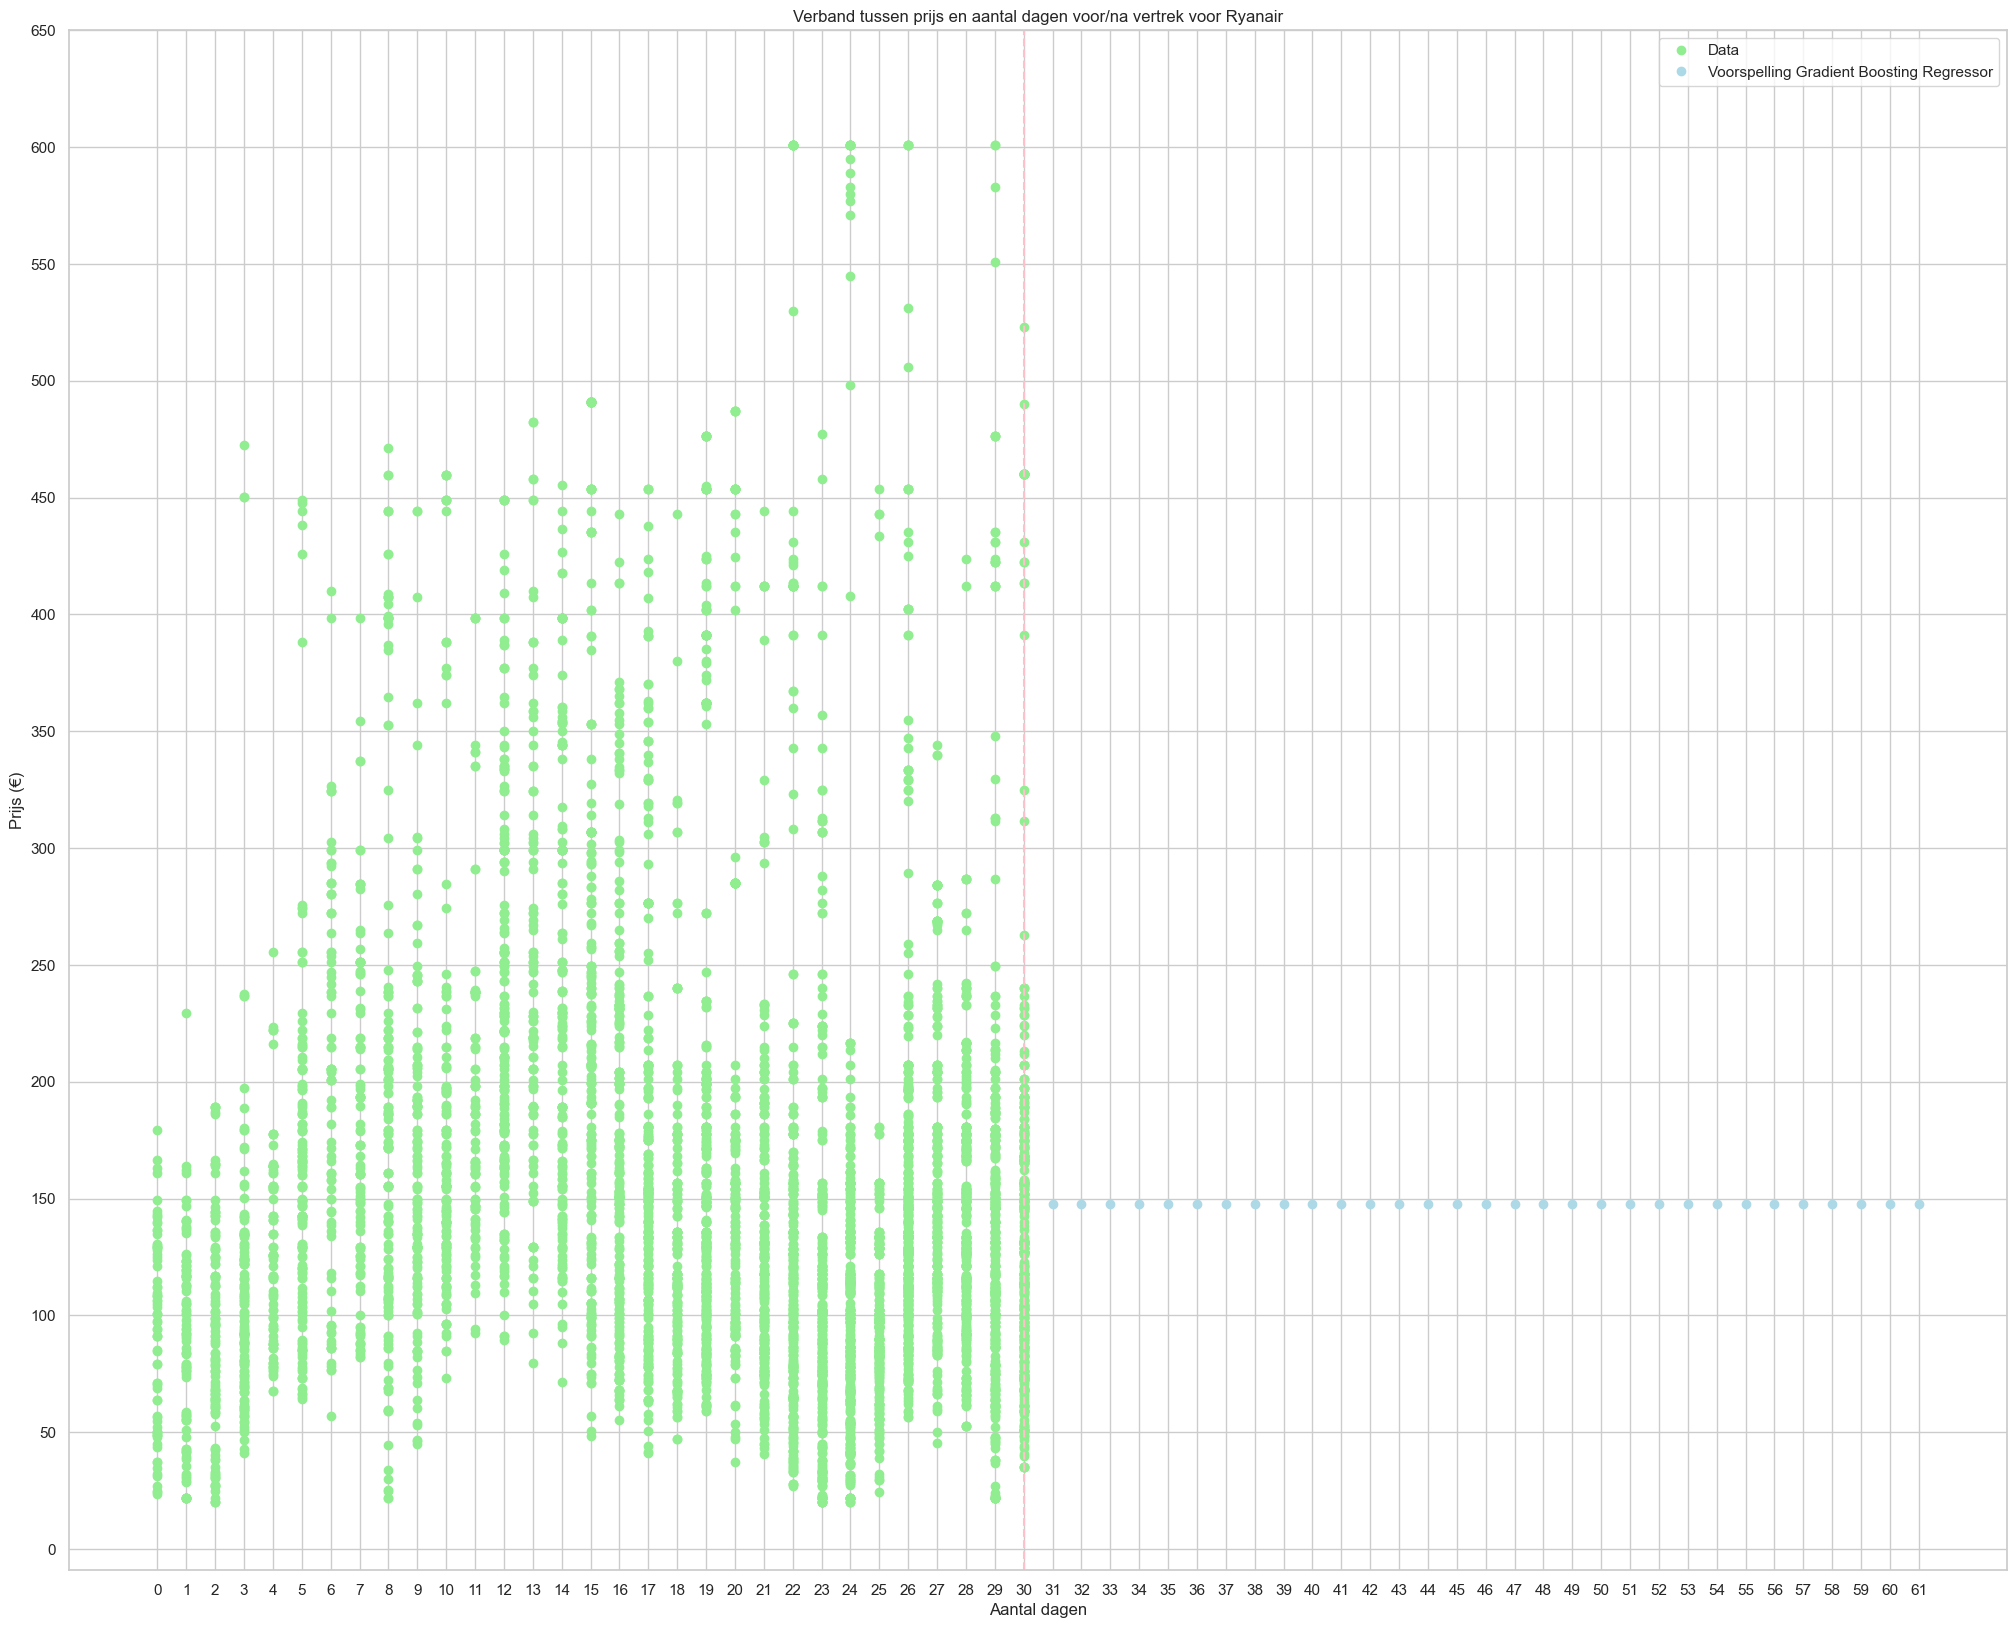

Accuracy score: 16.074942084852072 %
MSE: 7485.572410424178


In [29]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create gradient boosting regression model
gbr = GradientBoostingRegressor(random_state=42)

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
gbr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_gbr = gbr.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_gbr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling Gradient Boosting Regressor'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {gbr.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, gbr.predict(X_train))}")

##### Stochastic Gradient Descent Regressor

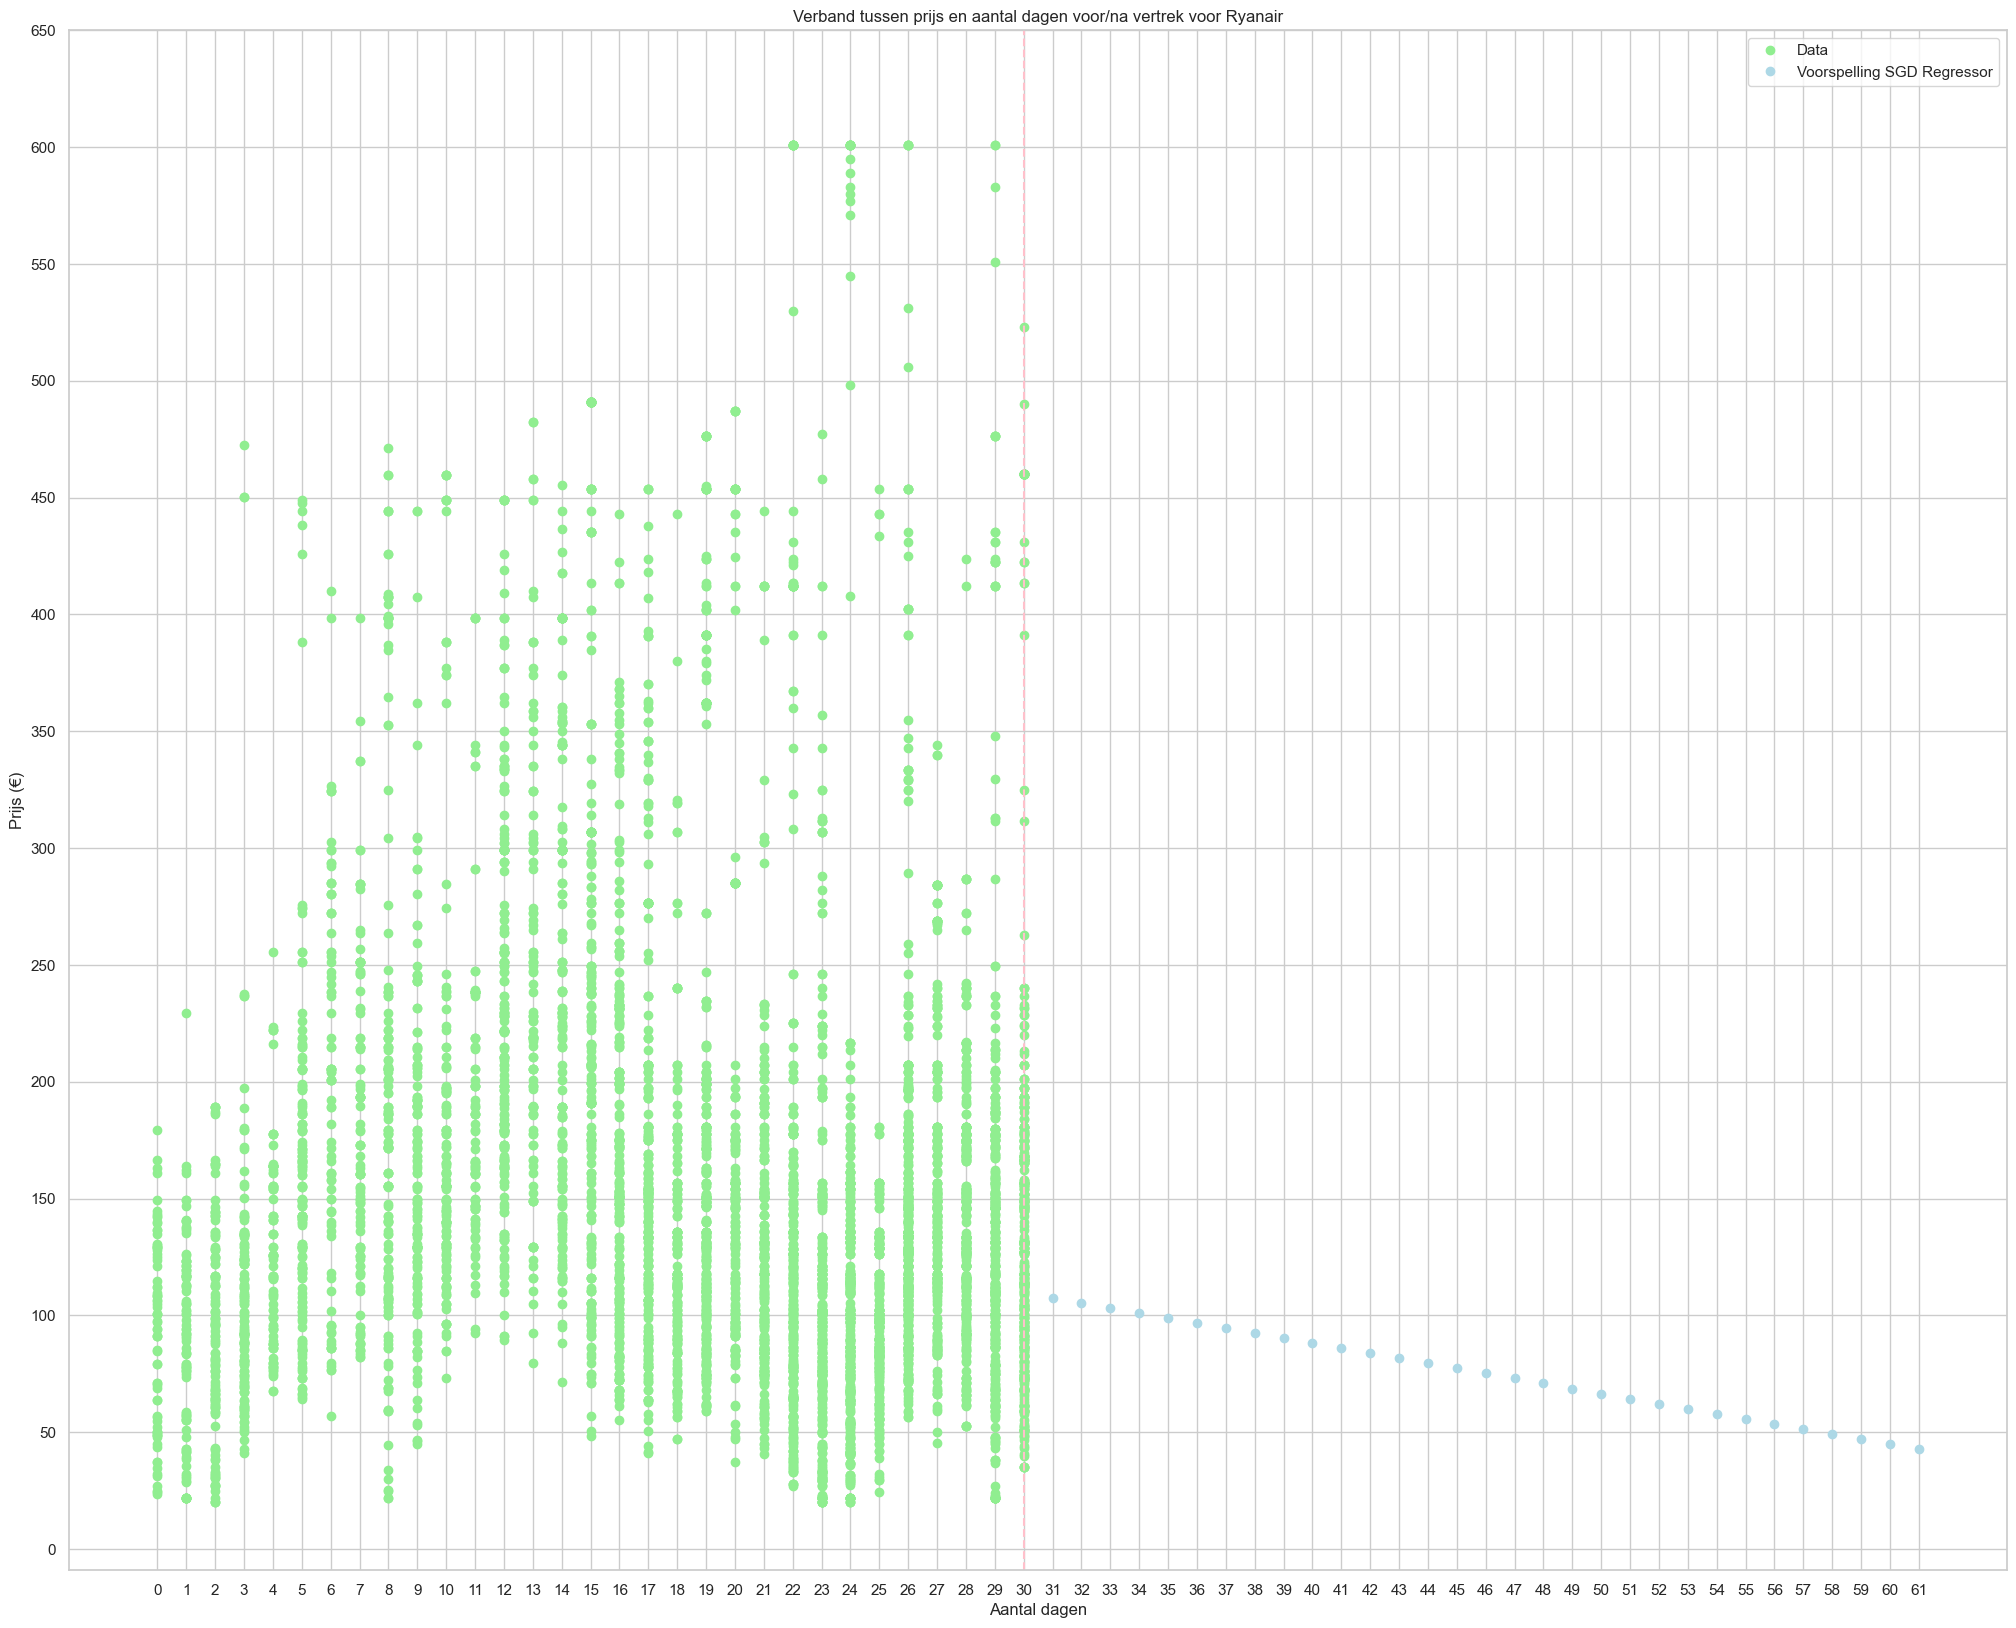

Accuracy score: -6.256565055777918 %
MSE: 9477.398426250118


In [30]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create sgd regression model
sgd = SGDRegressor(random_state=42)

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
sgd.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_sgd = sgd.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_sgd, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling SGD Regressor'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {sgd.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, sgd.predict(X_train))}")

##### SVR

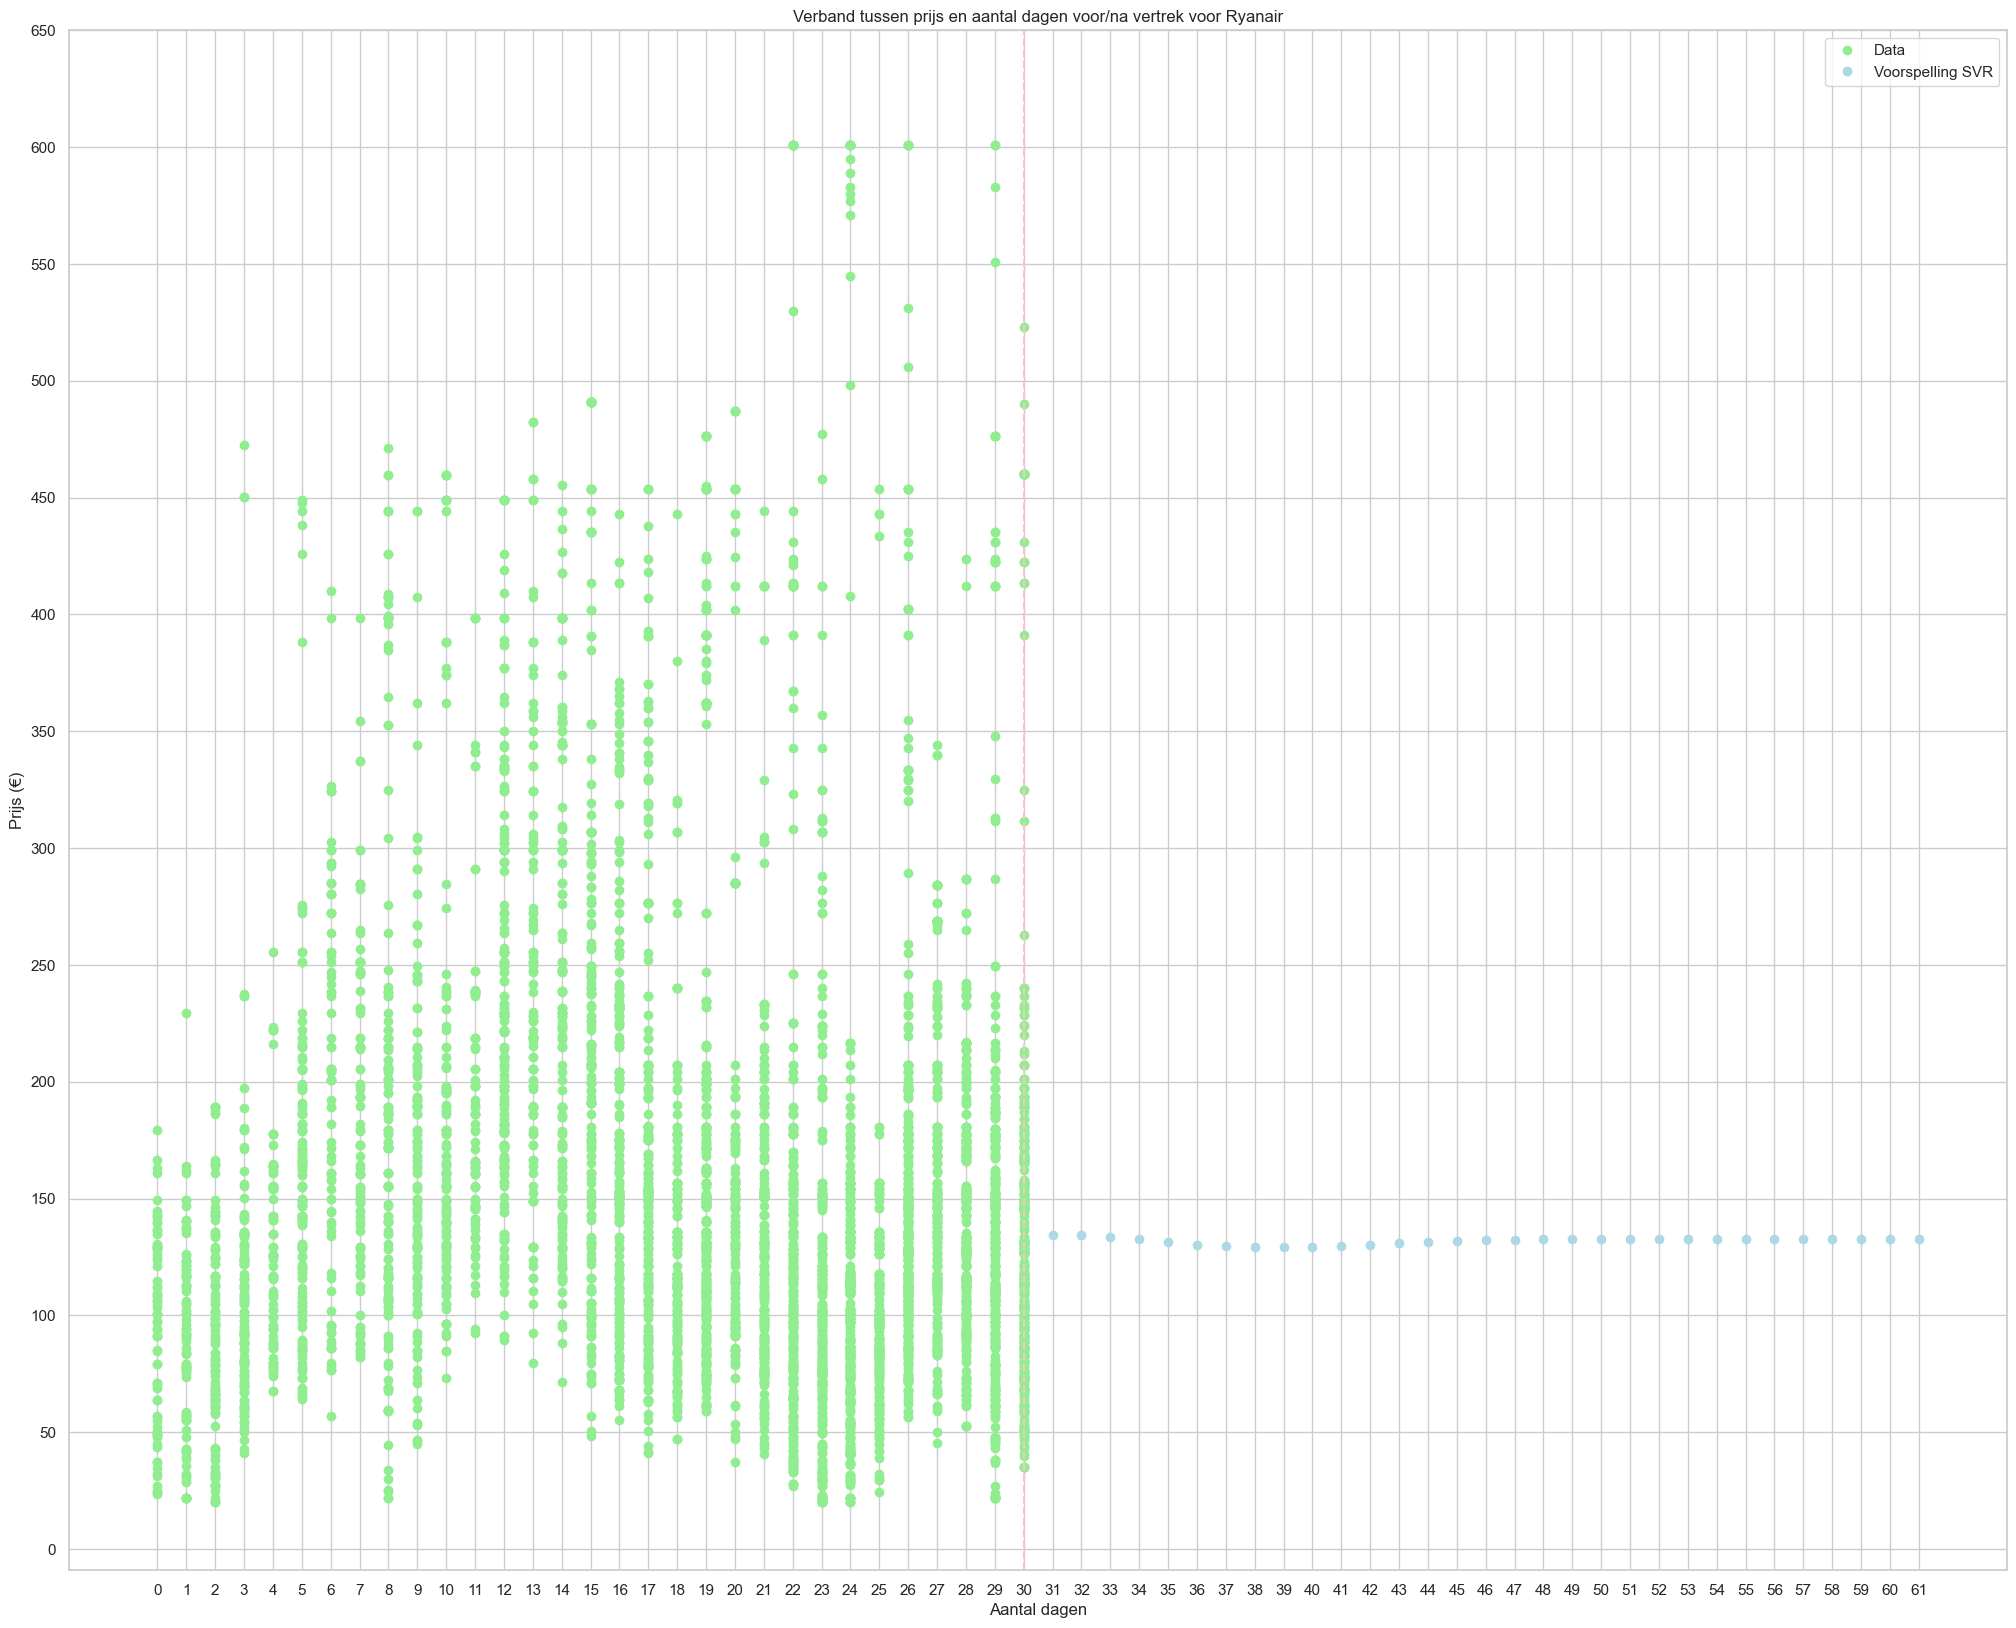

Accuracy score: 7.465917334021743 %
MSE: 8253.441742377809


In [31]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create svr regression model
svr = SVR()

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
svr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_svr = svr.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_svr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling SVR'])
plt.show()

# print the accuracy score and mse
print(f"Accuracy score: {svr.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, svr.predict(X_train))}")

##### Grid Search

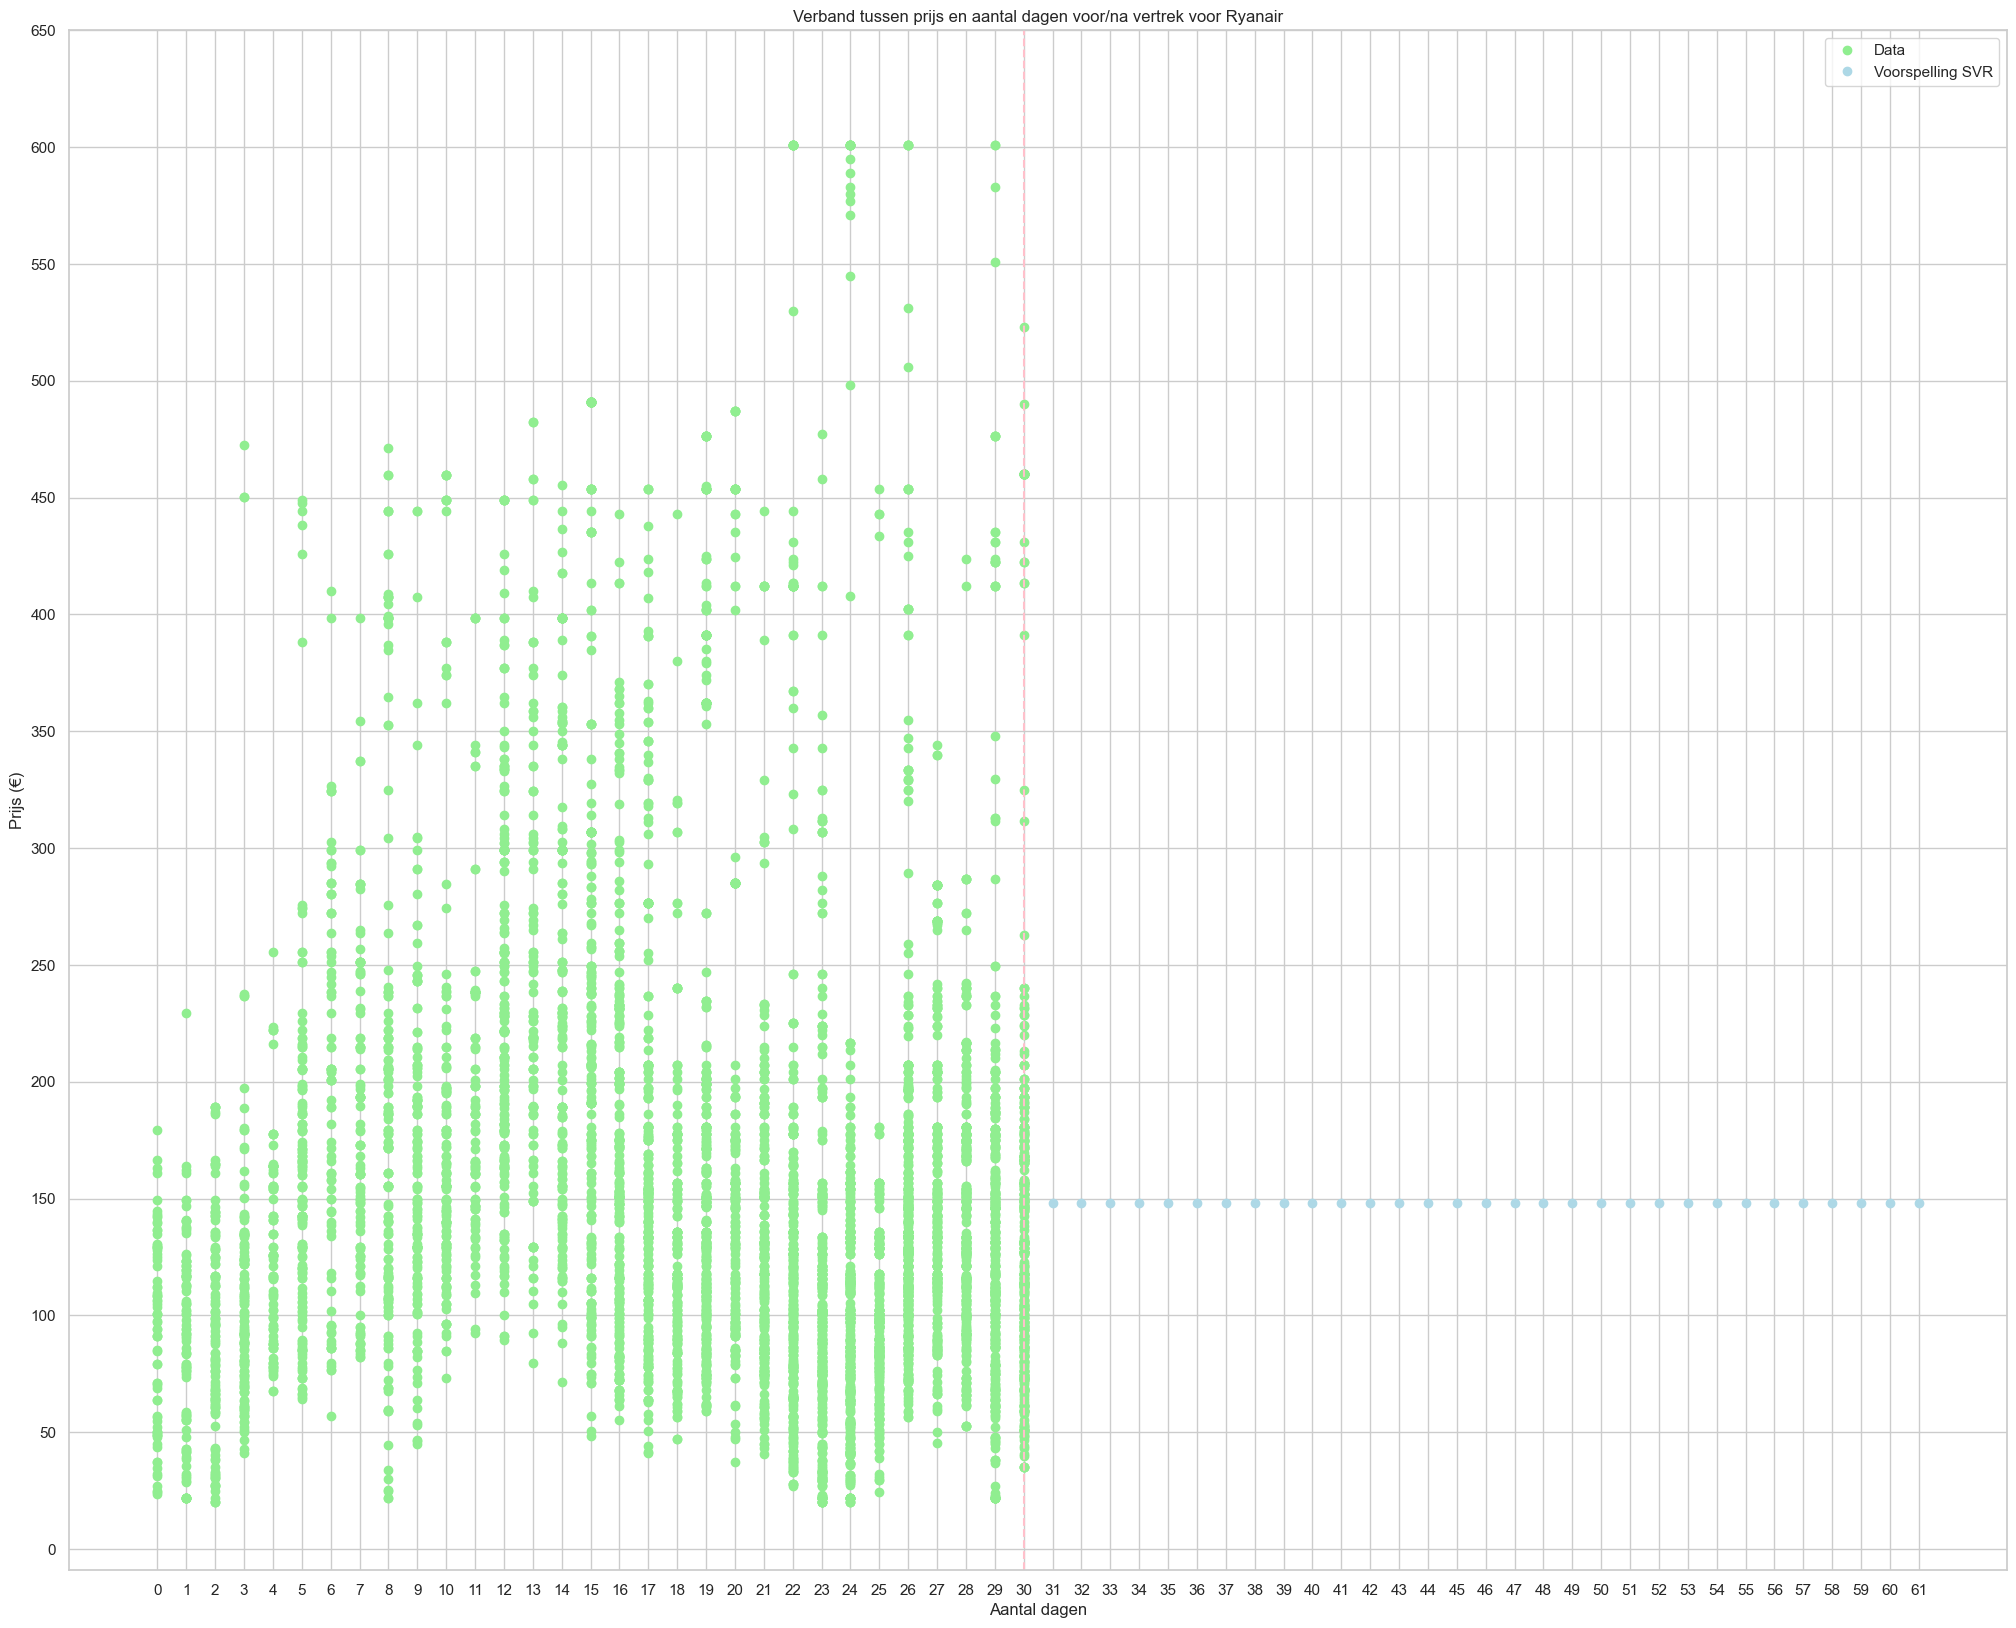

Accuracy score: 15.366135510798983 %
MSE: 7548.793372874075
Best parameters: {'max_depth': 4}
DecisionTreeRegressor(max_depth=4)
0.05405068188683002


In [32]:
# read data for Ryanair only
from sklearn.model_selection import GridSearchCV


data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create grid search model for decision tree regressor
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
dt = DecisionTreeRegressor()
clf = GridSearchCV(dt, parameters)

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
clf.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_svr = clf.predict(X_test)

# calculate the max price
max_price = data['price'].max()

# convert the max price to an integer
max_price = int(max_price)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_svr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.yticks(range(0, max_price + 100, 50))
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling SVR'])
plt.show()

# print the accuracy score and mse + best parameters
print(f"Accuracy score: {clf.score(X_train, y_train) * 100} %")
print(f"MSE: {mean_squared_error(y_train, clf.predict(X_train))}")
print(f"Best parameters: {clf.best_params_}")
print(clf.best_estimator_)
print(clf.best_score_)

##### Interpretatie van de grafieken

De x-as van bovenstaande grafieken moet je interpreteren als volgt: 
- Van 0 tot en met 30 zijn het aantal dagen voor vertrek (0 = 0 dagen voor vertrek, dus vandaag ; 30 = 30 dagen geleden).
- Van 31 tot en met 61 zijn de dagen van de komende maand (31 = morgen, 61 = volgende maand).

De y-as is de corresponderende prijs voor de specifieke dagen.

### 15) In PowerBI een kaart maken met de mogelijke bestemmingen als de prijs in een bepaalde range moet liggen (op een bepaald moment).

**PowerBI** &nbsp;&nbsp; *Vraag 15*